# Cobinding PiPeline: pre processing & analysis

In [166]:
import os
import pandas as pd
import sys
sys.path.insert(0, '../..')
import itertools
from scipy import stats

import numpy as np
from natsort import natsorted, ns

from genepy.epigenetics import chipseq as chip
from genepy.utils import helper
from genepy.utils import plot
from genepy.google import gcp
import igv
import SimpSOM as sps
from scipy import stats

import seaborn as sns
from matplotlib import cm
from matplotlib import pyplot as plt
from IPython.display import IFrame
import seaborn as sns
from bokeh.plotting import *
import igv

import numba
from numba import jit

from scipy.cluster.hierarchy import linkage, leaves_list
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans, OPTICS
from sklearn.mixture import GaussianMixture
from sklearn.manifold import MDS, TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from IPython.display import IFrame

from pybedtools import BedTool
import pyBigWig

output_notebook()
%load_ext autoreload
%autoreload 2

Loading BokehJS ...

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
project="Cobinding_ChIP"
version="v4"

## processing using Nextflow

In [ ]:
fastq = ! gsutil ls gs://amlproject/Chip/fastqs/paired_end/*MV411* # all other cell lines don't have the right INPUT
fastq

In [94]:
from gsheets import Sheets
# Here you might not need this line, otherwise you need to generate your json files from 
# https://pygsheets.readthedocs.io/en/stable/authorization.html
sheets = Sheets.from_files('~/.client_secret.json', '~/.storage.json')
url="https://docs.google.com/spreadsheets/d/1yFLjYB1McU530JnLgL0QIMAKIkVl3kl0_LCHje2gk8U"
gsheet = sheets.get(url).sheets[2].to_frame()

In [80]:
df = {
"fastq_1": [],
"fastq_2": [],
"antibody": [],
"group": [],
"replicate": [],
"control": []
}
for val in helper.grouped(fastq,2):
    row = gsheet[gsheet.id==val[0].split('/')[-1].split('-')[0]]
    df['group'].append(row['name'].values[0].split('-r')[0])
    df['replicate'].append(1)
    df['fastq_1'].append(val[0])
    df['fastq_2'].append(val[1])
    if row['matching input name'].values[0] is not None:
        df['antibody'].append(row['protein'].values[0])
        cont = gsheet[gsheet.id==row['matching input name'].values[0]]
        df['control'].append(cont['name'].values[0].split('-r')[0])
    else:
        df['antibody'].append("")
        df['control'].append("")
df = pd.DataFrame(df)
df[df.columns[[3,4,0,1,2,5]]].to_csv('../nextflow/'+project+'_paired_end_design.csv',index=False)

In [ ]:
fastq = ! gsutil ls gs://amlproject/Chip/fastqs/*.gz
fastq

In [98]:
df = {
"fastq_1": [],
"fastq_2": [],
"antibody": [],
"group": [],
"replicate": [],
"control": []
}
for val in fastq:
    row = gsheet[gsheet.id==val.split('/')[-1].split('-')[0]]
    if row['protein'].values[0] in ["IRF2BP2", "H3K27ac", "H3K36me3", "H3K27me3", "MED1", "H3K79me2", "H3K4me3", "H3K4me1", "H3K36me2", "H3K9ac", "H3K18", "BRD4"]:
        continue
    df['group'].append(row['name'].values[0].split('-r')[0])
    df['replicate'].append(1)
    df['fastq_1'].append(val)
    df['fastq_2'].append("")
    if row['matching input name'].values[0] is not None and row['matching input name'].values[0] is not np.nan:
        df['antibody'].append(row['protein'].values[0])
        cont = gsheet[gsheet.id==row['matching input name'].values[0]]
        df['control'].append(cont['name'].values[0].split('-r')[0])
    else:
        df['antibody'].append("")
        df['control'].append("")
df = pd.DataFrame(df)
df[df.columns[[3,4,0,1,2,5]]].to_csv('../nextflow/'+project+'_single_end_design_np.csv',index=False)

In [93]:
df = {
"fastq_1": [],
"fastq_2": [],
"antibody": [],
"group": [],
"replicate": [],
"control": []
}
for val in fastq:
    row = gsheet[gsheet.id==val.split('/')[-1].split('-')[0]]
    if row['protein'].values[0] not in ['INPUT',"IGG","IRF2BP2", "H3K27ac", "CEBPA", "H3K36me3", "PU1", "H3K27me3", "SMC1", "MED1", "H3K79me2", "H3K4me3", "H3K4me1", "H3K36me2", "H3K9ac", "CEBPB", "H3K18", "BRD4", "WDR5"]:
        continue
    df['group'].append(row['name'].values[0].split('-r')[0])
    df['replicate'].append(1)
    df['fastq_1'].append(val)
    df['fastq_2'].append("")
    if row['matching input name'].values[0] is not None and row['matching input name'].values[0] is not np.nan:
        df['antibody'].append(row['protein'].values[0])
        cont = gsheet[gsheet.id==row['matching input name'].values[0]]
        df['control'].append(cont['name'].values[0].split('-r')[0])
    else:
        df['antibody'].append("")
        df['control'].append("")
df = pd.DataFrame(df)
df[df.columns[[3,4,0,1,2,5]]].to_csv('../nextflow/'+project+'_single_end_design_bp.csv',index=False)

## Pipeline

![](images/gcpjup.png)


- Raw read QC (FastQC)
- Adapter trimming (Trim Galore!)
- Alignment (BWA)
- Mark duplicates (picard)
- Merge alignments from multiple libraries of the same sample (picard)
- Re-mark duplicates (picard)
- Filtering to remove: blacklisted regions, duplicates, primary alignments,unmapped,multiple locations, containing >  4 mismatches, insert size > 2kb, map to different chromosomes 
- Alignment-level QC and estimation of library complexity (picard, Preseq)
- Create normalised bigWig files scaled to 1 million mapped reads (BEDTools, bedGraphToBigWig)
- Generate gene-body meta-profile from bigWig files (deepTools)
- Calculate genome-wide IP enrichment relative to control (deepTools)
- Calculate strand cross-correlation peak and ChIP-seq quality measures including NSC and RSC (phantompeakqualtools)
- Call broad/narrow peaks (MACS2)
- Annotate peaks relative to gene features (HOMER)
- Create consensus peakset across all samples and create tabular file to aid in the filtering of the data (BEDTools)
- Count reads in consensus peaks (featureCounts)

![](images/nfcore.png)


## about
0. you need to have a google project set up with a billing account
1. you need to activte your APIs this way: https://cloud.google.com/life-sciences/docs/tutorials/nextflow?hl=fr
2. nextflow needs to be installed with this installation command `export NXF_MODE=google && curl https://get.nextflow.io | bash`
3. you will export the credentials to your google account (see google cloud oauth) `export GOOGLE_APPLICATION_CREDENTIALS=aml-chipseq-rnaseq-9dcbe47182cf.json`
4. look more about the chipseq pipeline here: https://nf-co.re/chipseq
5. now you can run the code as below (to run it locally, use `-profile docker`)
6. to run it on google cloud make a conf file with your google paymnt project id: `echo "google.project = 'YOUR_GOOGLE_PROJECT_ID'" >> my.config` and run the pipeline using: `-profile jkcloud --custom_local_config my.config`
7. to run it elsewhere, look at nf-core's documentation

In [ ]:
-profile #my profile for the cloud (to edit for your account) jkcloud
-w #where the withinput will be stored
--outdir #specify aa bucket+folderr where the results will be
--tracedir #you need to specify a local place for that
--custom_local_config custom_local.config #yoour custtom config

In [66]:
#process chips 
! ../../nextflow run jkobject/chipseq --paired_end --seq_center 'multiple' --email 'jkobject@gmail.com' --input ../nextflow/$project_paired_end_design.csv --genome 'GRCh38' --max_cpus 16 -profile 'jkcloud' -w gs://workamlproject/cobindingp --outdir gs://workamlproject/cobindingpres --tracedir ../nextflow/cobindingp/ --narrow_peak

.nextflow/history.lock (Permission denied)


In [ ]:
#calling narrow peak proteins in single end
! ../../nextflow run jkobject/chipseq --single_end --seq_center 'multiple' --email 'jkobject@gmail.com' --input ../nextflow/$project_single_end_design.csv --genome 'GRCh38' --max_cpus 16 -profile 'jkcloud' -w gs://workamlproject/cobindings --outdir gs://workamlproject/cobindingsres --tracedir ../nextflow/cobindings/ --narrow_peak

In [ ]:
#calling broad peak proteins in single end
! ../../nextflow run jkobject/chipseq --single_end --seq_center 'multiple' --email 'jkobject@gmail.com' --input ../nextflow/$project_single_end_broad_design.csv --genome 'GRCh38' --max_cpus 16 -profile 'jkcloud' -w gs://workamlproject/cobindingsb --outdir gs://workamlproject/cobindingsbres --tracedir ../nextflow/cobindingsb/

## Gathering data

we are using a folder outside our repository as there is too many huge files.

In [105]:
! gsutil -m cp -r gs://workamlproject/cobindingpres/* gs://amlproject/Chip/res/
#rename files: doing it once for each copy _pe, _se_bp, _se_np
helper.parrun(['gsutil mv '+i+' '+i.split('.')[0]+'_pe_np.'+i.split('.')[1] for i in ["gs://amlproject/Chip/res/multiqc/narrowPeak/multiqc_report.html",
"gs://amlproject/Chip/res/igv/narrowPeak/igv_files.txt",
"gs://amlproject/Chip/res/igv/narrowPeak/igv_session.xml",
"gs://amlproject/Chip/res/pipeline_info/design_controls.csv",
"gs://amlproject/Chip/res/pipeline_info/design_reads.csv",
"gs://amlproject/Chip/res/pipeline_info/results_description.html",
"gs://amlproject/Chip/res/pipeline_info/software_versions.csv"]],cores=8)

In [ ]:
! gsutil -m cp -r gs://workamlproject/cobindingsbpres/* gs://amlproject/Chip/res/
#rename files: doing it once for each copy _pe, _se_bp, _se_np
helper.parrun(['gsutil mv '+i+' '+i.split('.')[0]+'_se_bp.'+i.split('.')[1] for i in ["gs://amlproject/Chip/res/multiqc/broadPeak/multiqc_report.html",
"gs://amlproject/Chip/res/igv/narrowPeak/igv_files.txt",
"gs://amlproject/Chip/res/igv/narrowPeak/igv_session.xml",
"gs://amlproject/Chip/res/pipeline_info/design_controls.csv",
"gs://amlproject/Chip/res/pipeline_info/design_reads.csv",
"gs://amlproject/Chip/res/pipeline_info/results_description.html",
"gs://amlproject/Chip/res/pipeline_info/software_versions.csv"]],cores=8)

In [ ]:
! gsutil -m cp -r gs://workamlproject/cobindingsnpres/* gs://amlproject/Chip/res/
#rename files: doing it once for each copy _pe, _se_bp, _se_np
helper.parrun(['gsutil mv '+i+' '+i.split('.')[0]+'_se_np.'+i.split('.')[1] for i in ["gs://amlproject/Chip/res/multiqc/narrowPeak/multiqc_report.html",
"gs://amlproject/Chip/res/igv/narrowPeak/igv_files.txt",
"gs://amlproject/Chip/res/igv/narrowPeak/igv_session.xml",
"gs://amlproject/Chip/res/pipeline_info/design_controls.csv",
"gs://amlproject/Chip/res/pipeline_info/design_reads.csv",
"gs://amlproject/Chip/res/pipeline_info/results_description.html",
"gs://amlproject/Chip/res/pipeline_info/software_versions.csv"]],cores=8)

In [ ]:
! gsutil mv gs://amlproject/Chip/res/multiqc/broadPeak/* gs://amlproject/Chip/res/multiqc/
! gsutil mv gs://amlproject/Chip/res/multiqc/narrowPeak/* gs://amlproject/Chip/res/multiqc/
! gsutil mv gs://amlproject/Chip/res/igv/narrowPeak/* gs://amlproject/Chip/res/igv/
! gsutil mv gs://amlproject/Chip/res/igv/broadPeak/* gs://amlproject/Chip/res/igv/

In [ ]:
! mkdir ../../data/$project && mkdir ../../data/$project/peaks/ && mkdir ../../data/$project/wigs/
# getting the data for cobinding
! gsutil -m cp -r gs://amlproject/Chip/res/bwa/mergedLibrary/macs/*Peak/*Peak ../../data/$project/peaks
! gsutil -m cp -r gs://amlproject/Chip/res/bwa/mergedLibrary/bigwig/ ../../data/$project/wigs
# ading the chips from diffBinding DMSO
for val in ['chipseq_MEF2D_degraded','chipseq_IRF8_degraded']:
    ! gsutil -m cp -r gs://amlproject/Chip/$val/bwa/mergedLibrary/macs/*Peak/*DMSO*Peak ../../data/$project/peaks
    ! gsutil -m cp -r gs://amlproject/Chip/$val/bwa/mergedLibrary/bigwig/*DMSO* ../../data/$project/wigs

In [ ]:
bw

In [ ]:
#renaming samples from differential binding experiments
#files = ! ls ../../data/$project/MV411peak/*
bw = ! ls ../../data/$project/wigs/bigwig/*.bigWig
rn = {
'MV411_IRF8_NT_DMSO-IRF8': 'mp901-MV411_IRF8_NT_DMSO-IRF8-r1',
'MV411_IRF8_NT_DMSO-MED1': 'mp903-MV411_IRF8_NT_DMSO-MED1-r1',
'MV411_IRF8_NT_DMSO-MEF2C': 'mp905-MV411_IRF8_NT_DMSO-MEF2C-r1',
'MV411_IRF8_NT_DMSO-MEF2D': 'mp907-MV411_IRF8_NT_DMSO-MEF2D-r1',
'MV411_IRF8_NT_DMSO-MYC': 'mp909-MV411_IRF8_NT_DMSO-MYC-r1',
'MV411_IRF8_NT_DMSO-POLII_total': 'mp911-MV411_IRF8_NT_DMSO-POLII_total-r1',
'MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D': 'mp881-MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D-r3',
'MV411_MEF2D_NT_SC_63_DMSO-IFR8': 'mp883-MV411_MEF2D_NT_SC_63_DMSO-IRF8-r1',
'MV411_MEF2D_NT_SC_63_DMSO-MED1': 'mp885-MV411_MEF2D_NT_SC_63_DMSO-MED1-r1',
'MV411_MEF2D_NT_SC_63_DMSO-MEF2C': 'mp887-MV411_MEF2D_NT_SC_63_DMSO-MEF2C-r1',
'MV411_MEF2D_NT_SC_63_DMSO-MYC': 'mp889-MV411_MEF2D_NT_SC_63_DMSO-MYC-r1',
'MV411_MEF2D_NT_SC_63_DMSO-POLII': 'mp891-MV411_MEF2D_NT_SC_63_DMSO-POLII-r1', 
}
for i,v in rn.items():
    for val in bw:
        if i in val:
            n = val.replace(i,v)
            ! mv $val $n

In [ ]:
! mkdir ../../data/$project/MV411peak
! cp ../../data/$project/peaks/*MV411*.narrowPeak ../../data/$project/MV411peak/
! cp ../../data/$project/peaks/*MV411*.broadPeak ../../data/$project/MV411peak/

In [ ]:
#removing wrong peak calls (broad insteadd of narrow)
! rm ../../data/$project/MV411peak/mp577-MV411-SMC1_R1_peaks.broadPeak
! rm ../../data/$project/MV411peak/mp728-MV411_DMSO-CEBPA_R1_peaks.broadPeak
! rm ../../data/$project/MV411peak/mp112-MV411-CEBPA_R1_peaks.broadPeak
! rm ../../data/$project/MV411peak/mp115-MV411-PU1_R1_peaks.broadPeak
! rm ../../data/$project/MV411peak/mp428-MV411-PU1_R1_peaks.broadPeak

folder of peaks (broad and narrow) with everything from nextflow

In [ ]:
bindings = chip.loadPeaks(peakfolder = '../../data/'+project+'/MV411peak/', isMacs=False,skiprows=0)

In [ ]:
peaks = !ls ../../data/$project/MV411peak/*.narrowPeak
broadpeaks = ! ls ../../data/$project/MV411peak/*.broadPeak
peaks = set([i.split('/')[-1].split('.')[0] for i in broadpeaks]) | set([i.split('/')[-1].split('.')[0] for i in peaks])
peaks

## preprocessing the data and renaming

In [723]:
bindings = bindings[bindings['name']!="ATAC_MV411.mRp.clN_peaks"]

In [ ]:
version = "v4"

In [730]:
## setting good namings and TFs
bindings.loc[bindings[bindings['name'] == 'mp919-MV411_MEF2D_NT_SC_63-FLAF_MEF2D_R1_peaks'].index,'name'] = 'mp919-MV411_MEF2D_NT_SC_63-FLAG_MEF2D_R1_peaks'
bindings['replicate']= [i.split('-')[0] for i in bindings['name']]
bindings['tf'] = [i.split('-')[2].split('_R1')[0] for i in bindings['name']]
bindings['name'] = [i[:-9] for i in bindings['name']] 
bindings.loc[bindings[bindings['tf'].isin(['WDR5_429A','WDR5_D9E1'])].index,'tf'] = 'WDR5'
bindings.loc[bindings[bindings['tf']=="POLII_total"].index,'tf'] = 'POLII'
len(bindings),set(bindings['tf'])

(4647269,
 {'AFF4',
  'BRD4',
  'CDK13',
  'CDK9',
  'CEBPA',
  'CEBPB',
  'CTCF',
  'E2F3',
  'ELF2',
  'ETV6',
  'FLAG_GFI',
  'FLAG_IRF2BP2',
  'FLAG_MEF2C',
  'FLAG_MEF2D',
  'FLAG_PU1',
  'FLI1',
  'FOSL2',
  'FOXP1',
  'GATA2',
  'GFI1',
  'GSE1',
  'H3K18',
  'H3K27ac',
  'H3K27me3',
  'H3K36me2',
  'H3K36me3',
  'H3K4me1',
  'H3K4me3',
  'H3K79me2',
  'H3K9ac',
  'HEX',
  'HOXA9',
  'IKZF1',
  'IRF2BP2',
  'IRF8',
  'JUND',
  'LDB1',
  'LMO2',
  'LYL1',
  'MAX',
  'MED1',
  'MEF2C',
  'MEF2D',
  'MEIS1',
  'MLL_KTM2A',
  'MYB',
  'MYBL2',
  'MYC',
  'PLAGL2',
  'POLII',
  'PSER2',
  'PU1',
  'RARA',
  'RUNX1',
  'RUNX2',
  'RXRA',
  'SMC1',
  'SP1',
  'SREBP1',
  'STAT5B',
  'TFP4',
  'WDR5',
  'ZEB2',
  'ZFP281',
  'ZMYND8'})

__should be able to run just like this (it's from the github)__

In [13]:
project="Cobinding_ChIP"
version="v4"
old_version = "v3"

In [731]:
#bindings.to_csv('../results/'+project+'/large/'+version+'_all_bindings.bed.gz',sep='\t',index=False)

In [158]:
bindings= pd.read_csv('../results/'+project+'/large/'+old_version+'_all_bindings.bed.gz', 
                      sep='\t', index_col=None, header=0,
                      #names=["-log10pvalue","-log10qvalue", "chrom", "end", "foldchange", 
                      #       "name", "peak_number", "relative_summit_pos", "start", "replicate","tf"],
                      low_memory=False)

In [159]:
bindings.head()

,chrom,start,end,peak_number,foldchange,-log10pvalue,-log10qvalue,relative_summit_pos,name,tf,replicate
0,chr1,9936,10413,mp765-MV411-RUNX2_R1_peak_1,6.76346,16.3929,14.03930,235,mp765-MV411-RUNX2,RUNX2,mp765
1,chr1,9949,10426,mp764-MV411-RUNX2_R1_peak_1,4.73735,10.2238,8.08562,236,mp764-MV411-RUNX2,RUNX2,mp764
2,chr1,10017,10454,mp913-MV411-TFP4_R1_peak_1,20.13070,59.0413,55.10850,107,mp913-MV411-TFP4,TFP4,mp913
3,chr1,10020,10352,db55-MV411-RUNX1_R1_peak_1,9.01385,16.6963,13.72860,163,db55-MV411-RUNX1,RUNX1,db55
4,chr1,10034,10353,mp920-MV411-STAT5B_R1_peak_1,10.25160,29.4298,25.76380,94,mp920-MV411-STAT5B,STAT5B,mp920


In [225]:
print(bindings[bindings.tf.isin(["MEF2C", "FLAG_MEF2D"])].shape)
bindings[bindings.tf.isin(["MEF2C", "FLAG_MEF2D"])].head()

(171201, 11)


,chrom,start,end,peak_number,foldchange,-log10pvalue,-log10qvalue,relative_summit_pos,name,tf,replicate
10,chr1,10067,10343,mp874-MV411_MEF2D_NT_SC_63-FLAG_MEF2D_R1_peak_1,4.81162,10.03290,6.11962,159,mp874-MV411_MEF2D_NT_SC_63-FLAG_MEF2D,FLAG_MEF2D,mp874
11,chr1,10073,10324,mp919-MV411_MEF2D_NT_SC_63-FLAF_MEF2D_R1_peak_1,2.92316,5.82035,2.77905,213,mp919-MV411_MEF2D_NT_SC_63-FLAG_MEF2D,FLAG_MEF2D,mp919
15,chr1,10087,10317,mp614-MV411-MEF2C_R1_peak_1,5.91491,10.68010,6.74843,102,mp614-MV411-MEF2C,MEF2C,mp614
38,chr1,180760,181047,mp614-MV411-MEF2C_R1_peak_2,4.84395,10.76920,6.83359,134,mp614-MV411-MEF2C,MEF2C,mp614
58,chr1,181424,181679,mp919-MV411_MEF2D_NT_SC_63-FLAF_MEF2D_R1_peak_2,4.47605,10.87680,7.23841,94,mp919-MV411_MEF2D_NT_SC_63-FLAG_MEF2D,FLAG_MEF2D,mp919


In [224]:
from gsheets import Sheets
sheets = Sheets.from_files('~/.client_secret.json', '~/.storage.json')
url="https://docs.google.com/spreadsheets/d/1yFLjYB1McU530JnLgL0QIMAKIkVl3kl0_LCHje2gk8U"
# Chip_Tracker_JK
gsheet = sheets.get(url).sheets[10].to_frame()

In [305]:
# get MEF2C & FLAG_MEF2D samples
cobinding_tfs = ["MEF2C", "FLAG_MEF2C", "FLAG_MEF2D"] # ask about FLAG_MEF2C
gsheet_MEF2 = gsheet[gsheet.protein.isin(cobinding_tfs)]
# only good quality DMSO samples
gsheet_MEF2 = gsheet_MEF2[(~gsheet_MEF2["cell line"].str.contains("VHL"))]# & (gsheet_MEF2["quality"] != "bad")]
print(gsheet_MEF2.shape)

(21, 38)


In [306]:
gsheet.loc[gsheet.protein.isin(cobinding_tfs) & (~gsheet_MEF2["cell line"].str.contains("VHL")), 
           ["id", "cell line", "protein", "nextflow name", "bigwig", "Bigwigs"]]

,id,cell line,protein,nextflow name,bigwig,Bigwigs
117,mp581,MV411,MEF2C,mp581-MV411-MEF2C_R1,https://storage.cloud.google.com/amlproject/Ch...,NaN
139,mp614,MV411,MEF2C,mp614-MV411-MEF2C_R1,https://storage.cloud.google.com/amlproject/Ch...,NaN
141,mp627,MV411,MEF2C,mp627-MV411-MEF2C_R1,https://storage.cloud.google.com/amlproject/Ch...,NaN
183,mp760,MV411_MEF2D_NT_SC_63,FLAG_MEF2D,mp760-MV411_MEF2D_NT_SC_63-FLAG_MEF2D_R1,https://storage.cloud.google.com/amlproject/Ch...,NaN
302,mp874,MV411_MEF2D_NT_SC_63,FLAG_MEF2D,mp874-MV411_MEF2D_NT_SC_63-FLAG_MEF2D_R1,https://storage.cloud.google.com/amlproject/Ch...,https://console.cloud.google.com/storage/brows...
303,mp875,MV411_MEF2C_NT,FLAG_MEF2C,mp875-MV411_MEF2C_NT-FLAG_MEF2C_R1,https://storage.cloud.google.com/amlproject/Ch...,NaN
309,mp881,MV411_MEF2D_NT_SC_63_DMSO,FLAG_MEF2D,MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R1,https://storage.cloud.google.com/amlproject/Ch...,https://console.cloud.google.com/storage/brows...
315,mp887,MV411_MEF2D_NT_SC_63_DMSO,MEF2C,MV411_MEF2D_NT_SC_63_DMSO-MEF2C_R1,https://storage.cloud.google.com/amlproject/Ch...,NaN
333,mp905,MV411_IRF8_NT_DMSO,MEF2C,MV411_IRF8_NT_DMSO-MEF2C_R1,https://storage.cloud.google.com/amlproject/Ch...,NaN
343,mp915,MV411_MEF2D_NT_SC_63,FLAG_MEF2C,mp915-MV411_MEF2C_NT-MEF2C_R1,https://storage.cloud.google.com/amlproject/Ch...,NaN


In [307]:
# all sample ids in binding table
bindings_ids = [x.split("-")[0] for x in bindings["name"].tolist()]
print(len(bindings_ids))

# total # of unique binding ids
print(len(set(bindings_ids)))

# MEF2C & FLAG_MEF2D sample ids in gsheet
gsheet_ids = gsheet_MEF2.id.tolist()
print(len(gsheet_ids))

171201
10
21


In [309]:
# MEF2C & FLAG_MEF2D samples in binding
MEF2_bindings_samples = bindings.loc[bindings.tf.isin(cobinding_tfs), "name"].tolist()
MEF2_bindings_samples = natsorted(list(set(MEF2_bindings_samples)))
print(len(MEF2_bindings_samples))
print(MEF2_bindings_samples)

# gsheet samples in bindings
[x for x in gsheet_ids if x in [x.split("-")[0] for x in MEF2_bindings_samples]]

10


['mp581-MV411-MEF2C',
 'mp614-MV411-MEF2C',
 'mp627-MV411-MEF2C',
 'mp760-MV411_MEF2D_NT_SC_63-FLAG_MEF2D',
 'mp874-MV411_MEF2D_NT_SC_63-FLAG_MEF2D',
 'mp881-MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D-r3',
 'mp887-MV411_MEF2D_NT_SC_63_DMSO-MEF2C-r1',
 'mp905-MV411_IRF8_NT_DMSO-MEF2C-r1',
 'mp915-MV411_MEF2C_NT-MEF2C',
 'mp919-MV411_MEF2D_NT_SC_63-FLAG_MEF2D']

In [313]:
# gsheet samples in bindings
[x for x in gsheet_ids if x in [x.split("-")[0] for x in MEF2_bindings_samples]]

['mp581',
 'mp614',
 'mp627',
 'mp760',
 'mp874',
 'mp881',
 'mp887',
 'mp905',
 'mp915',
 'mp919']

In [314]:
# gsheet samples in bindings
print("common ids:\n{}".format(
    [x for x in gsheet_ids if x in [x.split("-")[0] for x in MEF2_bindings_samples]]))

# gsheet samples in NOT bindings
print("gsheet samples not in bindings:\n{}".format(
    [x for x in gsheet_ids if x not in [x.split("-")[0] for x in MEF2_bindings_samples]]))

# bindings samples NOT in gsheets
print("bindings samples not in gsheet:\n{}".format(
    [x for x in [x.split("-")[0] for x in MEF2_bindings_samples] if x not in gsheet_ids]))


common ids:
['mp581', 'mp614', 'mp627', 'mp760', 'mp874', 'mp881', 'mp887', 'mp905', 'mp915', 'mp919']
gsheet samples not in bindings:
['mp875', 'mp921', 'mp923', 'mp931', 'mp935', 'mp941', 'mp943', 'mp951', 'mp952', 'mp955', 'mp956']
bindings samples not in gsheet:
[]


In [315]:
common_ids = [x for x in gsheet_ids if x in [x.split("-")[0] for x in MEF2_bindings_samples]]
common_ids

['mp581',
 'mp614',
 'mp627',
 'mp760',
 'mp874',
 'mp881',
 'mp887',
 'mp905',
 'mp915',
 'mp919']

In [184]:
#gsheet_samples = gsheet_MEF2.loc[(~gsheet_MEF2["cell line"].str.contains("VHL")) & (gsheet_MEF2["quality"] != "bad"), "id"].tolist()


In [316]:
# samples in binding table
df_bigwig = gsheet_MEF2.loc[(gsheet_MEF2.id.isin(common_ids)), 
                            ["id", "cell line", "protein", "nextflow name", "bigwig", "Bigwigs"]]
df_bigwig

,id,cell line,protein,nextflow name,bigwig,Bigwigs
117,mp581,MV411,MEF2C,mp581-MV411-MEF2C_R1,https://storage.cloud.google.com/amlproject/Ch...,NaN
139,mp614,MV411,MEF2C,mp614-MV411-MEF2C_R1,https://storage.cloud.google.com/amlproject/Ch...,NaN
141,mp627,MV411,MEF2C,mp627-MV411-MEF2C_R1,https://storage.cloud.google.com/amlproject/Ch...,NaN
183,mp760,MV411_MEF2D_NT_SC_63,FLAG_MEF2D,mp760-MV411_MEF2D_NT_SC_63-FLAG_MEF2D_R1,https://storage.cloud.google.com/amlproject/Ch...,NaN
302,mp874,MV411_MEF2D_NT_SC_63,FLAG_MEF2D,mp874-MV411_MEF2D_NT_SC_63-FLAG_MEF2D_R1,https://storage.cloud.google.com/amlproject/Ch...,https://console.cloud.google.com/storage/brows...
309,mp881,MV411_MEF2D_NT_SC_63_DMSO,FLAG_MEF2D,MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R1,https://storage.cloud.google.com/amlproject/Ch...,https://console.cloud.google.com/storage/brows...
315,mp887,MV411_MEF2D_NT_SC_63_DMSO,MEF2C,MV411_MEF2D_NT_SC_63_DMSO-MEF2C_R1,https://storage.cloud.google.com/amlproject/Ch...,NaN
333,mp905,MV411_IRF8_NT_DMSO,MEF2C,MV411_IRF8_NT_DMSO-MEF2C_R1,https://storage.cloud.google.com/amlproject/Ch...,NaN
343,mp915,MV411_MEF2D_NT_SC_63,FLAG_MEF2C,mp915-MV411_MEF2C_NT-MEF2C_R1,https://storage.cloud.google.com/amlproject/Ch...,NaN
376,mp919,MV411_MEF2D_NT_SC_63,FLAG_MEF2D,mp919-MV411_MEF2D_NT_SC_63-FLAG_MEF2D_R1,https://storage.cloud.google.com/amlproject/Ch...,NaN


In [317]:
df_bigwig['prev_name'] = df_bigwig['nextflow name']

In [320]:
names = []
for idx in df_bigwig.index:
    if df_bigwig['prev_name'][idx].startswith('mp'):
        name = df_bigwig['prev_name'][idx]
        print(name)
    else:
        name = "-".join([df_bigwig['id'][idx], df_bigwig['prev_name'][idx]])
        print(name)
    names.append(name)
df_bigwig['name'] = names

mp581-MV411-MEF2C_R1
mp614-MV411-MEF2C_R1
mp627-MV411-MEF2C_R1
mp760-MV411_MEF2D_NT_SC_63-FLAG_MEF2D_R1
mp874-MV411_MEF2D_NT_SC_63-FLAG_MEF2D_R1
mp881-MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R1
mp887-MV411_MEF2D_NT_SC_63_DMSO-MEF2C_R1
mp905-MV411_IRF8_NT_DMSO-MEF2C_R1
mp915-MV411_MEF2C_NT-MEF2C_R1
mp919-MV411_MEF2D_NT_SC_63-FLAG_MEF2D_R1


In [322]:
df_bigwig

,id,cell line,protein,nextflow name,bigwig,Bigwigs,prev_name,name
117,mp581,MV411,MEF2C,mp581-MV411-MEF2C_R1,https://storage.cloud.google.com/amlproject/Ch...,NaN,mp581-MV411-MEF2C_R1,mp581-MV411-MEF2C_R1
139,mp614,MV411,MEF2C,mp614-MV411-MEF2C_R1,https://storage.cloud.google.com/amlproject/Ch...,NaN,mp614-MV411-MEF2C_R1,mp614-MV411-MEF2C_R1
141,mp627,MV411,MEF2C,mp627-MV411-MEF2C_R1,https://storage.cloud.google.com/amlproject/Ch...,NaN,mp627-MV411-MEF2C_R1,mp627-MV411-MEF2C_R1
183,mp760,MV411_MEF2D_NT_SC_63,FLAG_MEF2D,mp760-MV411_MEF2D_NT_SC_63-FLAG_MEF2D_R1,https://storage.cloud.google.com/amlproject/Ch...,NaN,mp760-MV411_MEF2D_NT_SC_63-FLAG_MEF2D_R1,mp760-MV411_MEF2D_NT_SC_63-FLAG_MEF2D_R1
302,mp874,MV411_MEF2D_NT_SC_63,FLAG_MEF2D,mp874-MV411_MEF2D_NT_SC_63-FLAG_MEF2D_R1,https://storage.cloud.google.com/amlproject/Ch...,https://console.cloud.google.com/storage/brows...,mp874-MV411_MEF2D_NT_SC_63-FLAG_MEF2D_R1,mp874-MV411_MEF2D_NT_SC_63-FLAG_MEF2D_R1
309,mp881,MV411_MEF2D_NT_SC_63_DMSO,FLAG_MEF2D,MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R1,https://storage.cloud.google.com/amlproject/Ch...,https://console.cloud.google.com/storage/brows...,MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R1,mp881-MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R1
315,mp887,MV411_MEF2D_NT_SC_63_DMSO,MEF2C,MV411_MEF2D_NT_SC_63_DMSO-MEF2C_R1,https://storage.cloud.google.com/amlproject/Ch...,NaN,MV411_MEF2D_NT_SC_63_DMSO-MEF2C_R1,mp887-MV411_MEF2D_NT_SC_63_DMSO-MEF2C_R1
333,mp905,MV411_IRF8_NT_DMSO,MEF2C,MV411_IRF8_NT_DMSO-MEF2C_R1,https://storage.cloud.google.com/amlproject/Ch...,NaN,MV411_IRF8_NT_DMSO-MEF2C_R1,mp905-MV411_IRF8_NT_DMSO-MEF2C_R1
343,mp915,MV411_MEF2D_NT_SC_63,FLAG_MEF2C,mp915-MV411_MEF2C_NT-MEF2C_R1,https://storage.cloud.google.com/amlproject/Ch...,NaN,mp915-MV411_MEF2C_NT-MEF2C_R1,mp915-MV411_MEF2C_NT-MEF2C_R1
376,mp919,MV411_MEF2D_NT_SC_63,FLAG_MEF2D,mp919-MV411_MEF2D_NT_SC_63-FLAG_MEF2D_R1,https://storage.cloud.google.com/amlproject/Ch...,NaN,mp919-MV411_MEF2D_NT_SC_63-FLAG_MEF2D_R1,mp919-MV411_MEF2D_NT_SC_63-FLAG_MEF2D_R1


In [324]:
rename = dict(zip(df_bigwig.prev_name, df_bigwig.name)) # make dict with names
rename

{'mp581-MV411-MEF2C_R1': 'mp581-MV411-MEF2C_R1',
 'mp614-MV411-MEF2C_R1': 'mp614-MV411-MEF2C_R1',
 'mp627-MV411-MEF2C_R1': 'mp627-MV411-MEF2C_R1',
 'mp760-MV411_MEF2D_NT_SC_63-FLAG_MEF2D_R1': 'mp760-MV411_MEF2D_NT_SC_63-FLAG_MEF2D_R1',
 'mp874-MV411_MEF2D_NT_SC_63-FLAG_MEF2D_R1': 'mp874-MV411_MEF2D_NT_SC_63-FLAG_MEF2D_R1',
 'MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R1': 'mp881-MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R1',
 'MV411_MEF2D_NT_SC_63_DMSO-MEF2C_R1': 'mp887-MV411_MEF2D_NT_SC_63_DMSO-MEF2C_R1',
 'MV411_IRF8_NT_DMSO-MEF2C_R1': 'mp905-MV411_IRF8_NT_DMSO-MEF2C_R1',
 'mp915-MV411_MEF2C_NT-MEF2C_R1': 'mp915-MV411_MEF2C_NT-MEF2C_R1',
 'mp919-MV411_MEF2D_NT_SC_63-FLAG_MEF2D_R1': 'mp919-MV411_MEF2D_NT_SC_63-FLAG_MEF2D_R1'}

In [327]:
# get bigwigs files
bw_list = df_bigwig["bigwig"].tolist()
bw_list = [bw.replace("https://storage.cloud.google.com/", "gs://") for bw in bw_list]
[bw_list[5],bw_list[6],bw_list[8]]

['gs://amlproject/Chip/MEF2D_degraded_v1/bwa/mergedLibrary/bigwig/MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R1.mLb.clN.bigWig',
 'gs://amlproject/Chip/MEF2D_degraded_v1/bwa/mergedLibrary/bigwig/MV411_MEF2D_NT_SC_63_DMSO-MEF2C_R1.mLb.clN.bigWig',
 'gs://amlproject/Chip/cobinding/bwa/mergedLibrary/bigwig/mp915-MV411_MEF2C_NT-MEF2C_R1.bigWig']

In [330]:
bw_list_download = [bw_list[5],bw_list[6],bw_list[8]]
# download bigwigs
for bigwig in bw_list_download:
    print(bigwig)
    ! gsutil cp $bigwig ../../data/$project/wigs/bigwig/

gs://amlproject/Chip/MEF2D_degraded_v1/bwa/mergedLibrary/bigwig/MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R1.mLb.clN.bigWig
Copying gs://amlproject/Chip/MEF2D_degraded_v1/bwa/mergedLibrary/bigwig/MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R1.mLb.clN.bigWig...
==> NOTE: You are downloading one or more large file(s), which would            
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

/ [1 files][816.1 MiB/816.1 MiB]   23.8 MiB/s                                   
Operation completed over 1 objects/816.1 MiB.                                    
gs://amlproject/Chip/MEF2D_degraded_v1/bwa/mergedLibrary/bigwig/MV411_MEF2D_NT_SC_63_DMSO-MEF2C_R1.mLb.clN.bigWig
Copying gs://amlproject/Chip/MEF2D_degraded_v1/bwa/mergedLibrary/bigwig/MV411_MEF2D_NT_SC_63_DMSO-MEF2C_R1.mLb.clN.bigWig...
==> NOTE: You are downloading one or more large file(s), which would            
run signifi

In [331]:
#renaming samples from differential binding experiments
#files = ! ls ../../data/$project/MV411peak/*
bw = ! ls ../../data/$project/wigs/bigwig/*.bigWig

for i,v in rename.items():
    for val in bw:
        if i in val:
            n = val.replace(i,v)
            print(val)
            print(n)
            ! mv $val $n
            print("\n")

../../data/Cobinding_ChIP/wigs/bigwig/mp581-MV411-MEF2C_R1.bigWig
../../data/Cobinding_ChIP/wigs/bigwig/mp581-MV411-MEF2C_R1.bigWig


mv: '../../data/Cobinding_ChIP/wigs/bigwig/mp581-MV411-MEF2C_R1.bigWig' and '../../data/Cobinding_ChIP/wigs/bigwig/mp581-MV411-MEF2C_R1.bigWig' are the same file
../../data/Cobinding_ChIP/wigs/bigwig/mp614-MV411-MEF2C_R1.bigWig
../../data/Cobinding_ChIP/wigs/bigwig/mp614-MV411-MEF2C_R1.bigWig


mv: '../../data/Cobinding_ChIP/wigs/bigwig/mp614-MV411-MEF2C_R1.bigWig' and '../../data/Cobinding_ChIP/wigs/bigwig/mp614-MV411-MEF2C_R1.bigWig' are the same file
../../data/Cobinding_ChIP/wigs/bigwig/mp627-MV411-MEF2C_R1.bigWig
../../data/Cobinding_ChIP/wigs/bigwig/mp627-MV411-MEF2C_R1.bigWig


mv: '../../data/Cobinding_ChIP/wigs/bigwig/mp627-MV411-MEF2C_R1.bigWig' and '../../data/Cobinding_ChIP/wigs/bigwig/mp627-MV411-MEF2C_R1.bigWig' are the same file
../../data/Cobinding_ChIP/wigs/bigwig/mp760-MV411_MEF2D_NT_SC_63-FLAG_MEF2D_R1.bigWig
../../data/Cobinding_ChIP/

In [385]:
bw = ! ls ../../data/$project/wigs/bigwig/*.bigWig
len(bw), bw

(10,
 ['../../data/Cobinding_ChIP/wigs/bigwig/mp581-MV411-MEF2C_R1.bigWig',
  '../../data/Cobinding_ChIP/wigs/bigwig/mp614-MV411-MEF2C_R1.bigWig',
  '../../data/Cobinding_ChIP/wigs/bigwig/mp627-MV411-MEF2C_R1.bigWig',
  '../../data/Cobinding_ChIP/wigs/bigwig/mp760-MV411_MEF2D_NT_SC_63-FLAG_MEF2D_R1.bigWig',
  '../../data/Cobinding_ChIP/wigs/bigwig/mp874-MV411_MEF2D_NT_SC_63-FLAG_MEF2D_R1.bigWig',
  '../../data/Cobinding_ChIP/wigs/bigwig/mp881-MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R1.mLb.clN.bigWig',
  '../../data/Cobinding_ChIP/wigs/bigwig/mp887-MV411_MEF2D_NT_SC_63_DMSO-MEF2C_R1.mLb.clN.bigWig',
  '../../data/Cobinding_ChIP/wigs/bigwig/mp905-MV411_IRF8_NT_DMSO-MEF2C_R1.bigWig',
  '../../data/Cobinding_ChIP/wigs/bigwig/mp915-MV411_MEF2C_NT-MEF2C_R1.bigWig',
  '../../data/Cobinding_ChIP/wigs/bigwig/mp919-MV411_MEF2D_NT_SC_63-FLAG_MEF2D_R1.bigWig'])

In [388]:
for i in bw:
    a = gsheet[gsheet.id==i.split("/")[-1].split("-")[0]].name.values[0]
    #i = '../../data/'+project+'/wigs/bigwig/'+i
    a = '../../data/'+project+'/wigs/bigwig/'+a+i.split("R1")[-1]
    print(i)
    print(a)
    print("\n")

mp581-MV411-MEF2C-r1
../../data/Cobinding_ChIP/wigs/bigwig/mp581-MV411-MEF2C_R1.bigWig
../../data/Cobinding_ChIP/wigs/bigwig/mp581-MV411-MEF2C-r1.bigWig


mp614-MV411-MEF2C-r2
../../data/Cobinding_ChIP/wigs/bigwig/mp614-MV411-MEF2C_R1.bigWig
../../data/Cobinding_ChIP/wigs/bigwig/mp614-MV411-MEF2C-r2.bigWig


mp627-MV411-MEF2C-r3
../../data/Cobinding_ChIP/wigs/bigwig/mp627-MV411-MEF2C_R1.bigWig
../../data/Cobinding_ChIP/wigs/bigwig/mp627-MV411-MEF2C-r3.bigWig


mp760-MV411_MEF2D_NT_SC_63-FLAG_MEF2D-r1
../../data/Cobinding_ChIP/wigs/bigwig/mp760-MV411_MEF2D_NT_SC_63-FLAG_MEF2D_R1.bigWig
../../data/Cobinding_ChIP/wigs/bigwig/mp760-MV411_MEF2D_NT_SC_63-FLAG_MEF2D-r1.bigWig


mp874-MV411_MEF2D_NT_SC_63-FLAG_MEF2D-r2
../../data/Cobinding_ChIP/wigs/bigwig/mp874-MV411_MEF2D_NT_SC_63-FLAG_MEF2D_R1.bigWig
../../data/Cobinding_ChIP/wigs/bigwig/mp874-MV411_MEF2D_NT_SC_63-FLAG_MEF2D-r2.bigWig


mp881-MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D-r3
../../data/Cobinding_ChIP/wigs/bigwig/mp881-MV411_MEF2D_NT_

In [382]:
bw[2].split("R1")[-1]

'.bigWig'

In [389]:
# ONE off
for i in bw[2:]:
    a = gsheet[gsheet.id==i.split("/")[-1].split("-")[0]].name.values[0]
    print(a)
    a = '../../data/'+project+'/wigs/bigwig/'+a+i.split("R1")[-1]
    ! mv $i $a

mp627-MV411-MEF2C-r3
mp760-MV411_MEF2D_NT_SC_63-FLAG_MEF2D-r1
mp874-MV411_MEF2D_NT_SC_63-FLAG_MEF2D-r2
mp881-MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D-r3
mp887-MV411_MEF2D_NT_SC_63_DMSO-MEF2C-r1
mp905-MV411_IRF8_NT_DMSO-MEF2C-r1
mp915-MV411_MEF2D_NT_SC_63-FLAG_MEF2C-r2
mp919-MV411_MEF2D_NT_SC_63-FLAG_MEF2D-r3


In [ ]:
replicates = chiphelper.findReplicates(folder='../data/seqs/results/bwa/', sep='_', namings='_R([0-9])',namepos=0)

## Visual inspection of the features and and look at QCs

### igv tracks
use `gs://amlproject/Chip/res/igv/igv_session_all.xml` as a session file from server in the https://igv.org/app

### multiQC
look at all files in this [bucket folder](https://console.cloud.google.com/storage/browser/amlproject/Chip/res/multiqc/)

### annotate bad quality chips: 

1. look at all replicates with a very low frip score (as noted by encode: <1%). 

2. look at all peaks tracks together and see for location of intense co binding. 
    - if we can discern peaks and if, for some reasons, some good peaks are not called by macs. 
    - if looks good and we can see a lot of peaks. 
    - if a lot of noise but seems consistent with replicates. 
    - if just seems to have very few peaks.


In [285]:
#badquality samples: frip score below 1% or duplications > 40%
bad=gsheet.loc[gsheet.quality=="bad",gsheet.columns[0]].tolist()
#["db29", "db30", "db31", "db32", "db34", "db37", "db38", "db40", "db41", "db42", "db43", "db44", "db45", 
#"db47", "db49", "db52", "dp51", "mp115", "mp117", "mp118", "mp124", "mp125", "mp128", "mp129", "mp154", "mp156", 
#"mp168", "mp171", "mp196", "mp27", "mp27", "mp33", "mp35", "mp358", "mp424", "mp425", "mp427", "mp428", "mp430", 
#"mp431", "mp433", "mp565", "mp568", "mp569", "mp570", "mp575", "mp581", "mp589", "mp590", "mp601", "mp604", 
#"mp607", "mp614", "mp623", "mp627", "mp631", "mp636", "mp638", "mp639", "mp640", "mp650", "mp690", "mp714", 
#"mp715", "mp716", "mp717", "mp718", "mp724", "mp728", "mp739", "mp741", "mp742", "mp743", "mp745", "mp748", 
#"mp750", "mp751", "mp770", "mp771", "mp773", "mp772", "mp774", "mp878", "mp321", "mp874", "mp324", "mp875", 
#"mp879", "mp880", "mp913", "mp914", "mp915", "mp916", "mp917","mp887"]

In [340]:
bad=gsheet.loc[(gsheet.quality=="bad") & (gsheet.protein.isin(cobinding_tfs)), gsheet.columns[0]].tolist()
bad

['mp881', 'mp887', 'mp888']

## merging duplicates

This function takes as an input a bed-like df file. It should be a concatenation of 1 or many chip experiment with at least some with multiple replicates.

It will merge the replicate based on the following logic:

1. look at peak overlaps by merging everything as one peaks f within a defined window (default: )
2. take the -if possible, non bad quality- sample with the most peaks as the main peak
3. for every other peak:
    1. we compare them
        - if there is no minimum overlap and one is bad quality we drop it
        - if there is no minimum overlap and both are good quality we ask if we should try to continue or discard the TF entirely. 
        - if there is some minimum overlap amount, we continue
    2. we look in the main replicate's bigwig, if we can recover some peaks where we had data from the other replicate. we used a poisson distribution that we fit to the background and the peak location and compare them using a KL divergence metric. If it is above the threshold, we report the fold-change value and p_values
    3. we do the same for the other replicate's bigwig under the main replicate's peaks.
    4. when we merge the new peaks, we recompute the global pvalue of the peak and average its fold-change across all replicates
4. all peaks reported under the main replicate (including recovered ones) or present in more than 2 other replicates are used as the "peaks in the merged version".


In [341]:
bindings = bindings[bindings.tf.isin(cobinding_tfs)]

In [344]:
# gsheet samples in bindings
print("common ids:\n{}".format(
    [x for x in gsheet_ids if x in [x.split("-")[0] for x in MEF2_bindings_samples]]))
# gsheet samples in NOT bindings
print("gsheet samples not in bindings:\n{}".format(
    [x for x in gsheet_ids if x not in [x.split("-")[0] for x in MEF2_bindings_samples]]))
# bindings samples NOT in gsheets
print("bindings samples not in gsheet:\n{}".format(
    [x for x in [x.split("-")[0] for x in MEF2_bindings_samples] if x not in gsheet_ids]))


common ids:
['mp581', 'mp614', 'mp627', 'mp760', 'mp874', 'mp881', 'mp887', 'mp905', 'mp915', 'mp919']
gsheet samples not in bindings:
['mp875', 'mp921', 'mp923', 'mp931', 'mp935', 'mp941', 'mp943', 'mp951', 'mp952', 'mp955', 'mp956']
bindings samples not in gsheet:
[]


In [347]:
bad

['mp881', 'mp887', 'mp888']

In [350]:
sorted(list(set(bindings["replicate"].tolist())))

['mp581',
 'mp614',
 'mp627',
 'mp760',
 'mp874',
 'mp881',
 'mp887',
 'mp905',
 'mp915',
 'mp919']

In [360]:
bindings[bindings["replicate"] == "mp887"].head()

,chrom,start,end,peak_number,foldchange,-log10pvalue,-log10qvalue,relative_summit_pos,name,tf,replicate
113,chr1,261731,262752,MV411_MEF2D_NT_SC_63_DMSO-MEF2C_R1_peak_1,2.15544,3.92782,1.56102,1021,mp887-MV411_MEF2D_NT_SC_63_DMSO-MEF2C-r1,MEF2C,mp887
285,chr1,783259,784295,MV411_MEF2D_NT_SC_63_DMSO-MEF2C_R1_peak_2,2.14396,3.87969,1.53396,1036,mp887-MV411_MEF2D_NT_SC_63_DMSO-MEF2C-r1,MEF2C,mp887
457,chr1,840356,840666,MV411_MEF2D_NT_SC_63_DMSO-MEF2C_R1_peak_3,2.11999,3.77216,1.46591,310,mp887-MV411_MEF2D_NT_SC_63_DMSO-MEF2C-r1,MEF2C,mp887
512,chr1,879963,880349,MV411_MEF2D_NT_SC_63_DMSO-MEF2C_R1_peak_4,2.18844,5.18011,2.45300,386,mp887-MV411_MEF2D_NT_SC_63_DMSO-MEF2C-r1,MEF2C,mp887
10073,chr1,2996331,2997080,MV411_MEF2D_NT_SC_63_DMSO-MEF2C_R1_peak_5,2.16460,3.97551,1.58968,749,mp887-MV411_MEF2D_NT_SC_63_DMSO-MEF2C-r1,MEF2C,mp887


In [391]:
from genepy.epigenetics.CREME import mergeReplicatePeaks

In [395]:
'../results/'+project+'/plots/'+version+'/'

'../results/Cobinding_ChIP/plots/v4/'

/!/ should only be passed peaks with at least one good replicate
Testing findAdditionalPeaks
_____________________________________________________
merging MEF2C peaks
--> finish first overlaps lookup


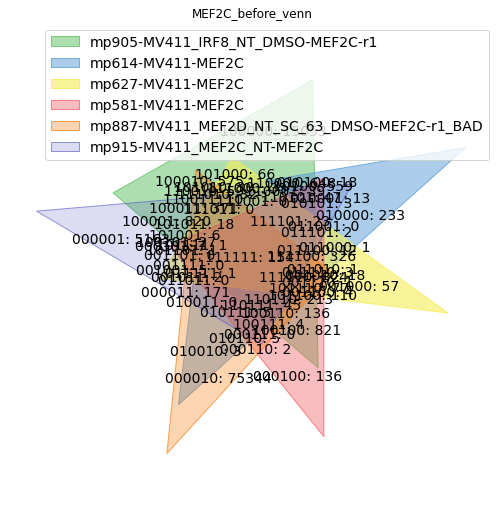

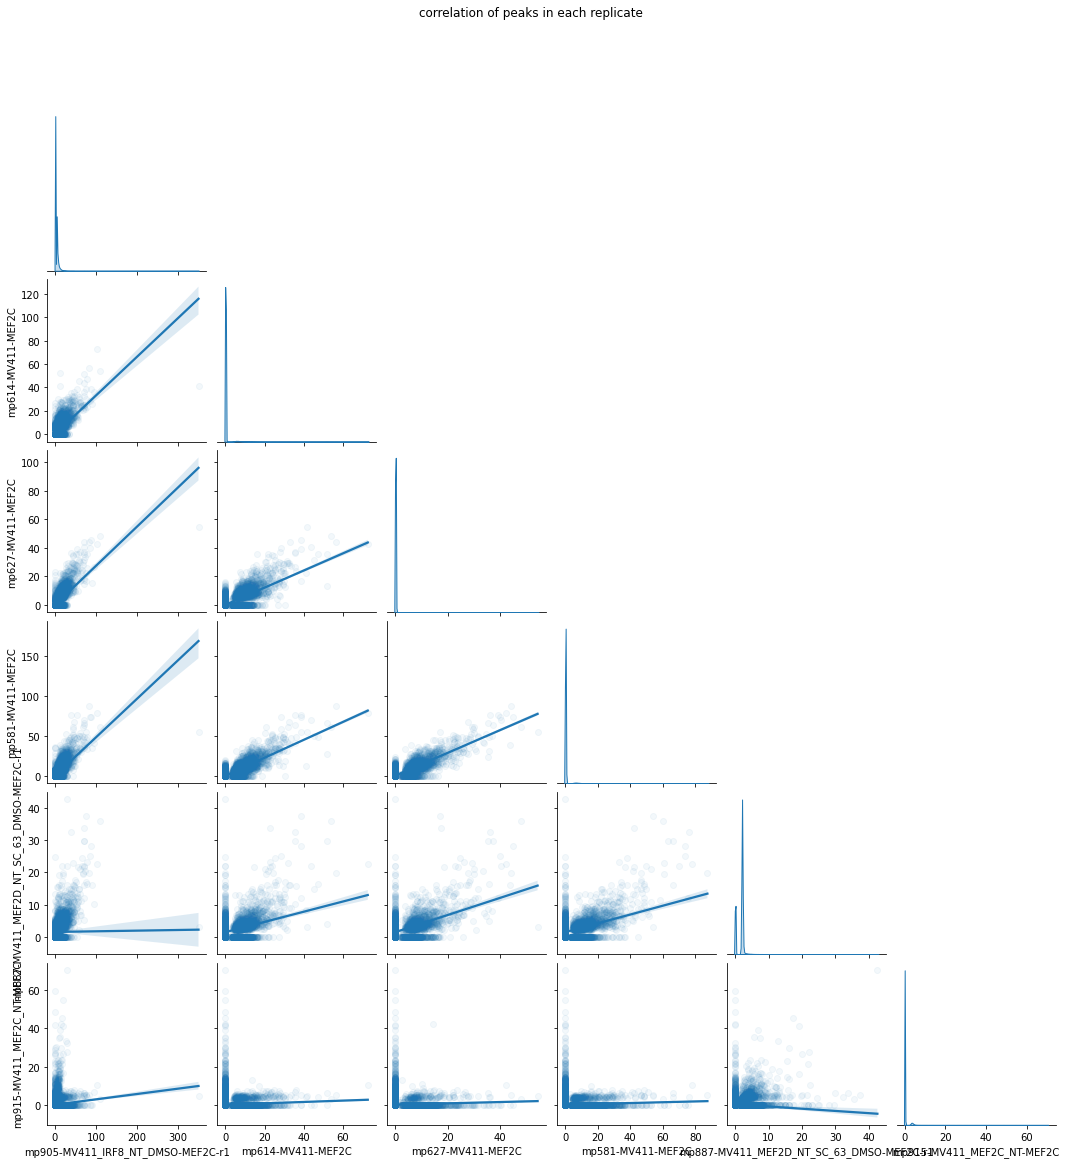

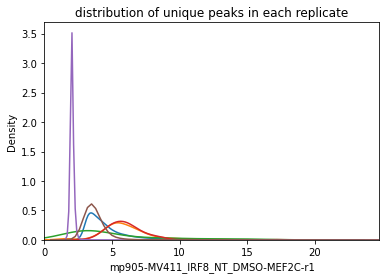

-> main rep is: mp905-MV411_IRF8_NT_DMSO-MEF2C-r1
- mp887-MV411_MEF2D_NT_SC_63_DMSO-MEF2C-r1
  overlap: 12.06455887921242%
 --> not enough overlap
  not using this replicate from the peakmatrix
- mp581-MV411-MEF2C
  overlap: 15.940931465354033%
 --> not enough overlap
mp581-MV411-MEF2C
  min,max from newly found peaks: (7.040918534048185, 72.70574935646731)
  we did not had enough initial overlap.
 --> enough overlap
mp905-MV411_IRF8_NT_DMSO-MEF2C-r1
  min,max from newly found peaks: (0.48671344799355865, 169.93515721981112)
  we have recovered 3964 peaks, equal to 15.84079283887468% of the peaks in main replicate
  enough from small overlap to advice to merge the peaks
- mp614-MV411-MEF2C
  overlap: 14.255963650132525%
 --> not enough overlap
mp614-MV411-MEF2C
  min,max from newly found peaks: (6.134014378741286, 75.09572796999112)
  we did not had enough initial overlap.
 --> enough overlap
  we have recovered 4050 peaks, equal to 16.184462915601024% of the peaks in main replicate
  

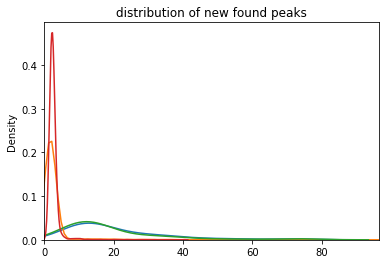

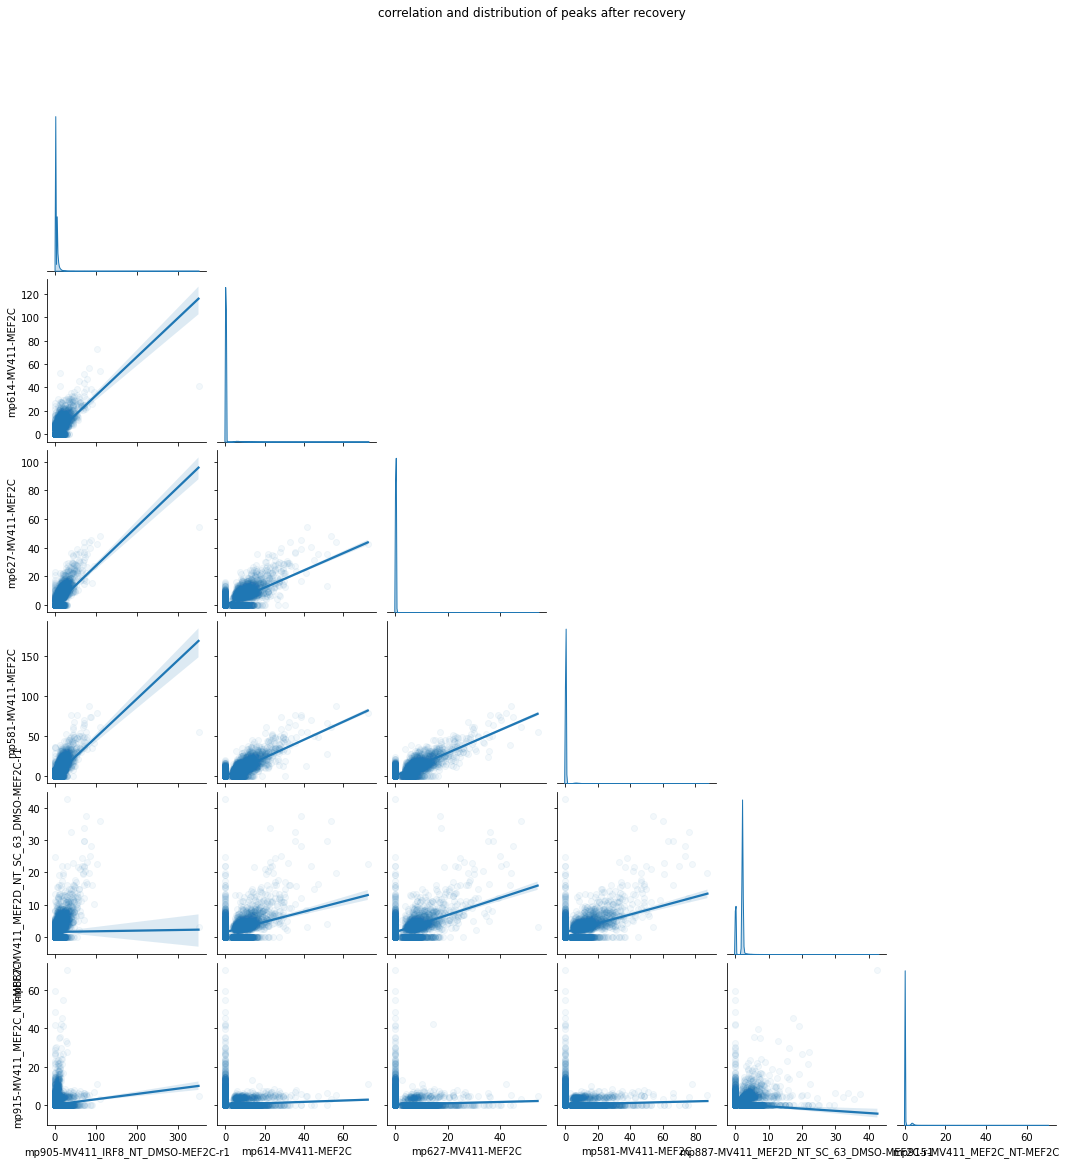

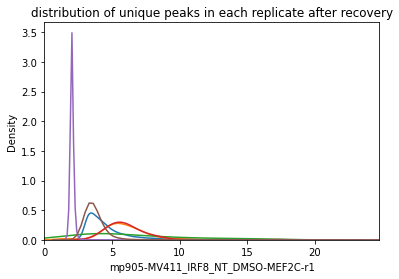

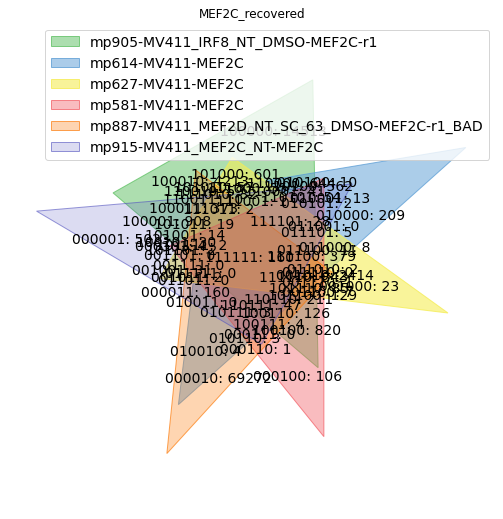

('MEF2C', 25076)
_____________________________________________________
merging FLAG_MEF2D peaks
--> finish first overlaps lookup


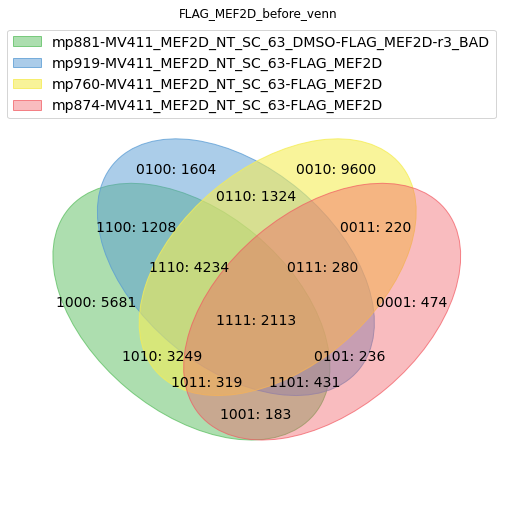

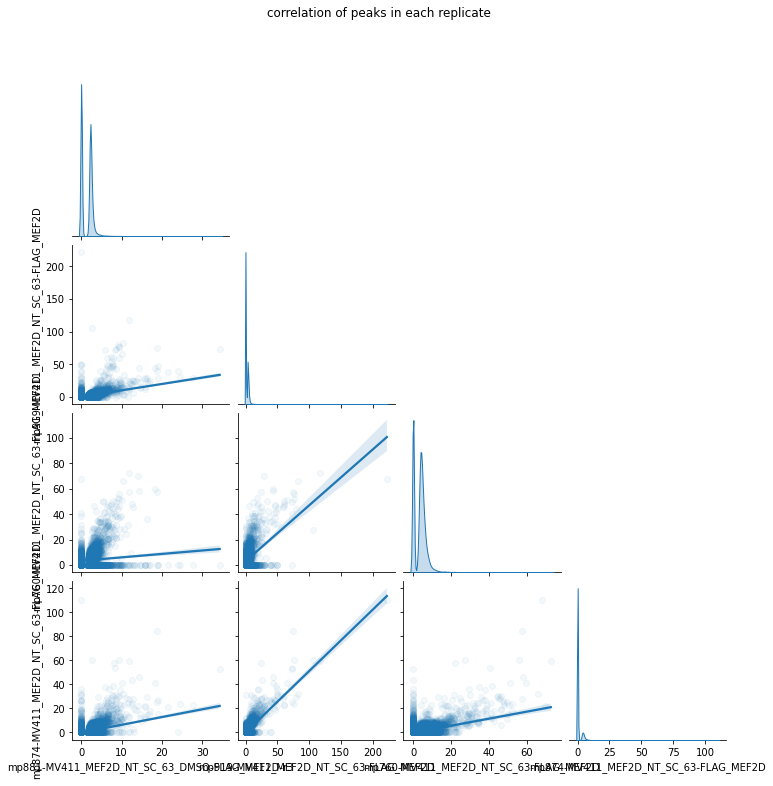

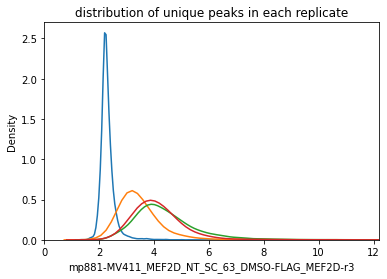

-> main rep is: mp760-MV411_MEF2D_NT_SC_63-FLAG_MEF2D
- mp881-MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D-r3
  overlap: 46.46422044144524%
mp881-MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D-r3
  min,max from newly found peaks: (1.5363590576822281, 151.22174512195429)
 --> enough overlap
mp760-MV411_MEF2D_NT_SC_63-FLAG_MEF2D
  min,max from newly found peaks: (4.414773074326121, 55.44424937859321)
  we have recovered 2212 peaks, equal to 10.131452388586085% of the peaks in main replicate
- mp919-MV411_MEF2D_NT_SC_63-FLAG_MEF2D
  overlap: 37.26041520221191%
mp919-MV411_MEF2D_NT_SC_63-FLAG_MEF2D
  min,max from newly found peaks: (0.7741555813017188, 63.01453912699982)
 --> enough overlap
  we have recovered 2571 peaks, equal to 11.775752301561855% of the peaks in main replicate
- mp874-MV411_MEF2D_NT_SC_63-FLAG_MEF2D
  overlap: 13.740100285861567%
 --> not enough overlap
mp874-MV411_MEF2D_NT_SC_63-FLAG_MEF2D
  min,max from newly found peaks: (0.4161773125712006, 105.99330008535313)
  we did not had enoug

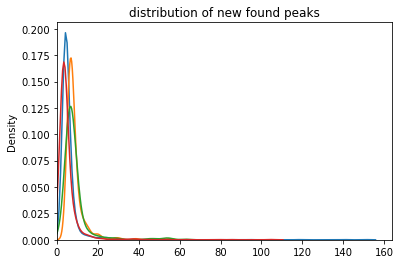

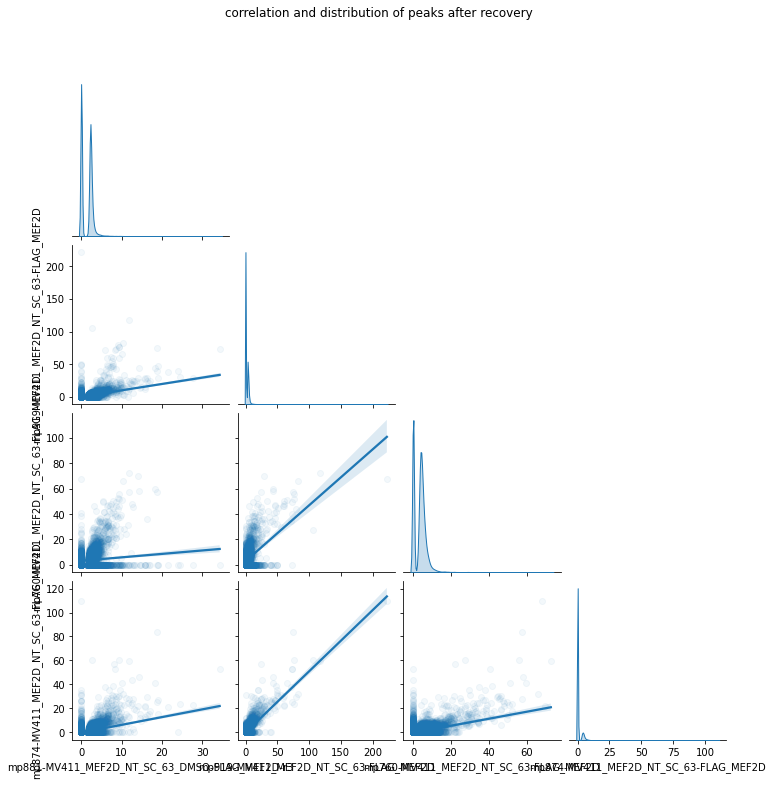

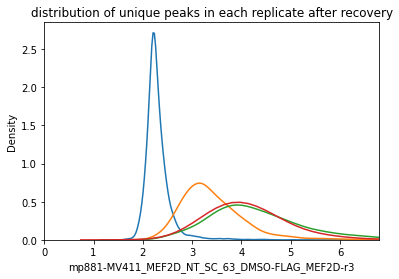

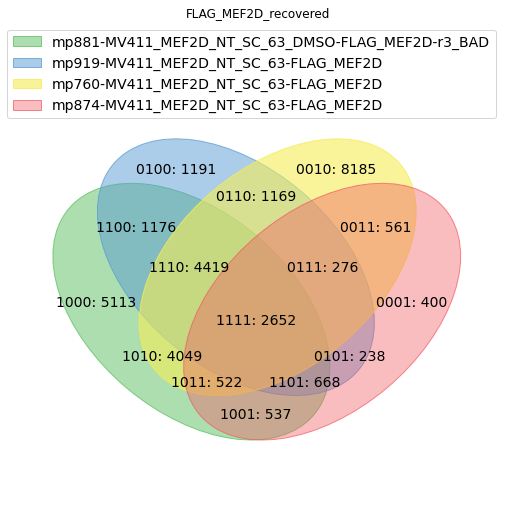

('FLAG_MEF2D', 22739)


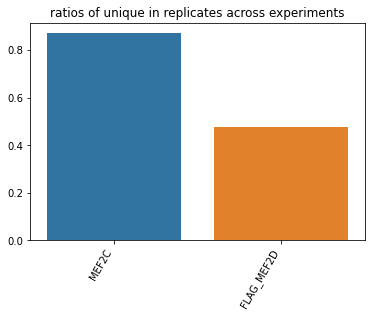

CPU times: user 1h 4min 58s, sys: 12min 35s, total: 1h 17min 34s
Wall time: 52min 41s


In [392]:
%%time
%matplotlib inline

mergedpeak, tomergebam, remove, ratiosofunique = mergeReplicatePeaks(bindings,
    '../../data/'+project+'/wigs/bigwig/', markedasbad=bad, window=150, mincov=4, doPlot=True, minKL=10, cov={},
    use='poisson', MINOVERLAP=0.25, lookeverywhere=True, only='', saveloc='../results/'+project+'/plots/'+version+'/')

/!/ should only be passed peaks with at least one good replicate
_____________________________________________________
merging MEF2C peaks
--> finish first overlaps lookup


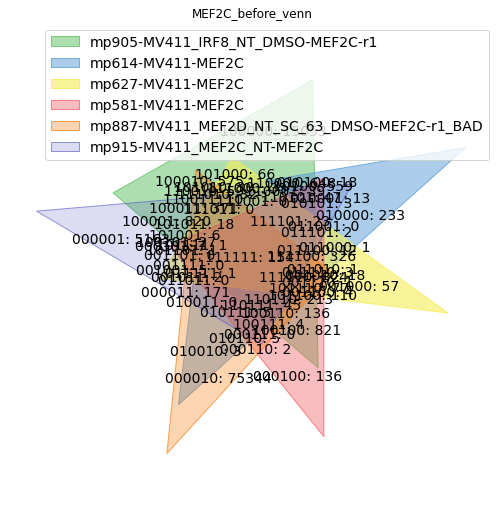

KeyboardInterrupt: 

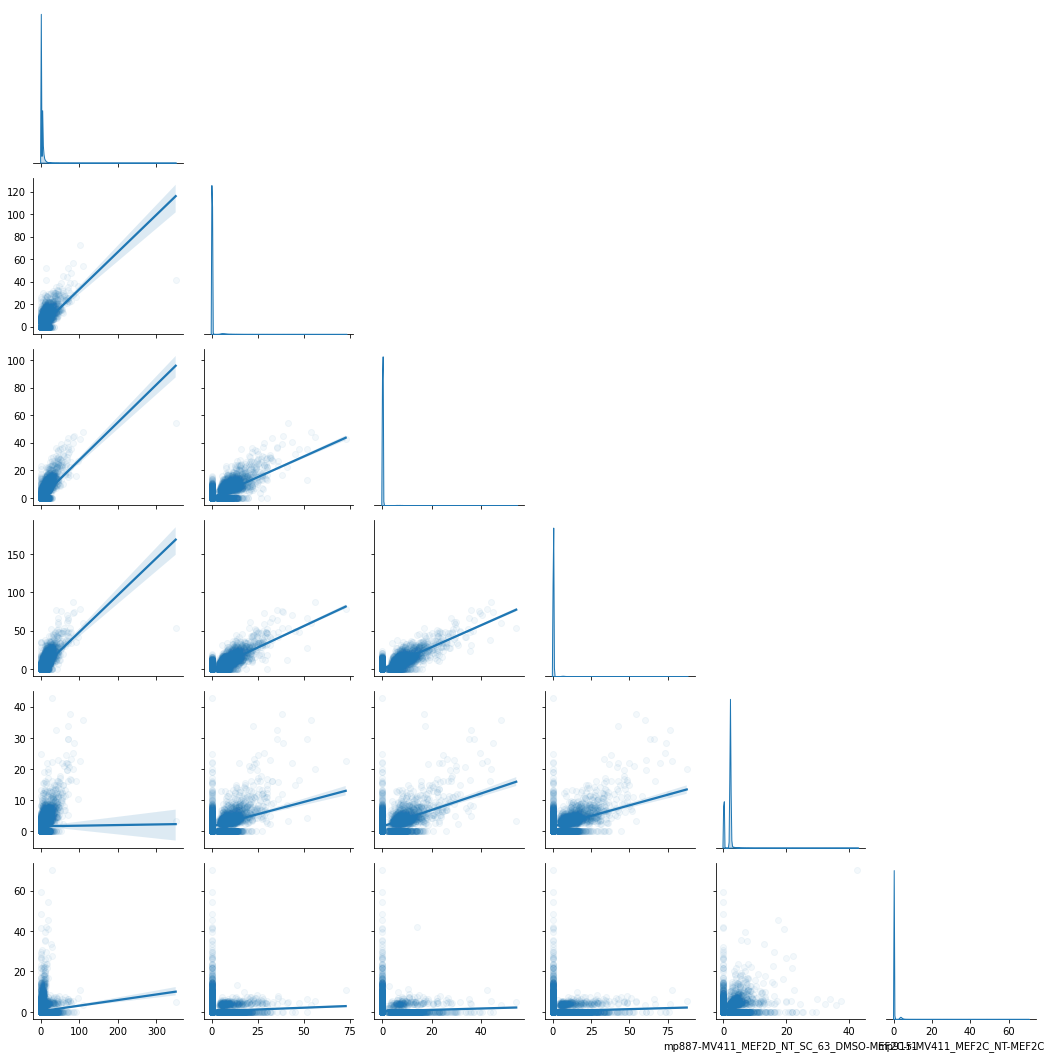

In [293]:
%matplotlib inline
mergedpeak, tomergebam, remove, ratiosofunique = mergeReplicatePeaks(bindings,
    '../../data/'+project+'/wigs/bigwig/', markedasbad=bad, window=150, mincov=4, doPlot=True, minKL=10, cov={},
    use='poisson', MINOVERLAP=0.25, lookeverywhere=True, only='', saveloc='../results/'+project+'/plots/'+version+'/')

In [817]:
mergedpeak #= mergedpeak[mergedpeak.columns[[2,9,3,5,6,4,0,1,7,10]]]

,chrom,start,end,peak_number,foldchange,-log10pvalue,-log10qvalue,relative_summit_pos,name,tf
0,chr1,10087,10317,0,5.914910,1.068010e+01,6.748430e+00,134,MEF2C,MEF2C
1,chr1,180760,181047,1,4.843950,1.076920e+01,6.833590e+00,134,MEF2C,MEF2C
2,chr1,183562,184551,2,3.851040,3.916524e+01,9.580449e+00,636,MEF2C,MEF2C
3,chr1,261731,262752,3,2.155440,3.927820e+00,1.561020e+00,1021,MEF2C,MEF2C
4,chr1,605257,605586,4,3.837510,5.112510e+00,2.433650e+00,329,MEF2C,MEF2C
...,...,...,...,...,...,...,...,...,...,...
28493,chrY,56715020,56715854,102322,14.657783,1.485973e+05,9.279942e+04,425,MEF2C,MEF2C
28494,chrY,56720710,56721183,102324,3.987447,5.592550e+02,1.071451e+02,370,MEF2C,MEF2C
28495,chrY,56751860,56752350,102327,2.314990,1.082143e+03,2.585016e+02,203,MEF2C,MEF2C
28496,chrY,56763271,56763586,102329,1.970413,2.576388e+06,2.256173e+06,215,MEF2C,MEF2C


In [740]:
tomergebam

[['mp299-MV411-CEBPA', 'mp72-MV411-CEBPA'],
 ['mp299-MV411-CEBPA', 'mp728-MV411_DMSO-CEBPA'],
 ['mp299-MV411-CEBPA', 'mp112-MV411-CEBPA'],
 ['mp583-MV411-ELF2', 'mp607-MV411-ELF2'],
 ['mp771-MV411-JUND', 'mp772-MV411-JUND'],
 ['mp773-MV411-HOXA9', 'mp774-MV411-HOXA9'],
 ['mp718-MV411-IRF2BP2', 'mp430-MV411-IRF2BP2'],
 ['mp718-MV411-IRF2BP2', 'mp431-MV411-IRF2BP2'],
 ['mp425-MV411-ETV6', 'mp569-MV411-ETV6'],
 ['mp70-MV411-H3K27ac', 'mp702-MV411_DMSO-H3K27ac'],
 ['mp70-MV411-H3K27ac', 'mp734-MV411_DMSO-H3K27ac'],
 ['mp70-MV411-H3K27ac', 'mp88-MV411-H3K27ac'],
 ['mp70-MV411-H3K27ac', 'mp136-MV411-H3K27ac'],
 ['db55-MV411-RUNX1', 'mp300-MV411-RUNX1'],
 ['db55-MV411-RUNX1', 'mp424-MV411-RUNX1'],
 ['db55-MV411-RUNX1', 'mp129-MV411-RUNX1'],
 ['mp767-MV411-FOXP1', 'mp768-MV411-FOXP1'],
 ['mp587-MV411-IKZF1', 'mp604-MV411-IKZF1'],
 ['db46-MV411-BRD4', 'db47-MV411-BRD4'],
 ['mp325-MV411-SP1', 'mp426-MV411-SP1'],
 ['mp325-MV411-SP1', 'mp118-MV411-SP1'],
 ['mp301-MV411-PU1', 'mp428-MV411-PU1'],
 [

In [738]:
# TFs that you might want to remove because of their quality
remove

['WDR5', 'GATA2', 'MEF2C']

## sorting and removing samples

In [739]:
rename = {'FLAG_GFI':'FLAG_GFI1', 'FLAG_PU1':'FLAG_SPI1', 'PU1':'SPI1', 'ZFP281':'ZNF281', 'TFP4':'TFAP4','SREBP1':'SREBF1'}
mergedpeak.tf = mergedpeak.tf.replace(rename)

In [742]:
#what tfs do we have in our set?
tfs = set(mergedpeak.tf)
tfs

{'AFF4',
 'BRD4',
 'CDK13',
 'CDK9',
 'CEBPA',
 'CEBPB',
 'CTCF',
 'E2F3',
 'ELF2',
 'ETV6',
 'FLAG_GFI1',
 'FLAG_IRF2BP2',
 'FLAG_MEF2C',
 'FLAG_MEF2D',
 'FLAG_SPI1',
 'FLI1',
 'FOSL2',
 'FOXP1',
 'GATA2',
 'GFI1',
 'GSE1',
 'H3K18',
 'H3K27ac',
 'H3K27me3',
 'H3K36me2',
 'H3K36me3',
 'H3K4me1',
 'H3K4me3',
 'H3K79me2',
 'H3K9ac',
 'HEX',
 'HOXA9',
 'IKZF1',
 'IRF2BP2',
 'IRF8',
 'JUND',
 'LDB1',
 'LMO2',
 'LYL1',
 'MAX',
 'MED1',
 'MEF2C',
 'MEF2D',
 'MEIS1',
 'MLL_KTM2A',
 'MYB',
 'MYBL2',
 'MYC',
 'PLAGL2',
 'POLII',
 'PSER2',
 'RARA',
 'RUNX1',
 'RUNX2',
 'RXRA',
 'SMC1',
 'SP1',
 'SPI1',
 'SREBF1',
 'STAT5B',
 'TFAP4',
 'WDR5',
 'ZEB2',
 'ZMYND8',
 'ZNF281'}

In [741]:
mergedpeak.to_csv('../results/'+project+'/large/merged_replicates_'+version+'.csv.gz')

In [ ]:
bigwigs=os.listdir('../../data/bigwig/')
for val in bigwigs:
    for v in remove + toremove + ['scale','POLII','IGG','CTCF','INPUT']:
        if v in val:
            bigwigs.remove(val)
            break
bigwigs = ['data/bigwig/'+ i for i in bigwigs]

## Consensus set

In [970]:
window = 150
merging_version = "simpleMerge"

In [13]:
#getting the crcs
crc = helper.fileToList('../data/CRCs.txt')
crc = set(crc) & set(tfs)
#merging all the crc to create the cobinding matrix. keeping he flag versions 
keep = ['FLAG_MEF2D','FLAG_GFI1']
remove = ['MEF2D','GFI1','FLAG_IRF2BP2','FLAG_MEF2C','FLAG_SPI1','H3K18','GSE1','HEX']
crc = (set(crc)|set(keep))-set(remove)

In [971]:

mergedpeak['name'] = mergedpeak.tf
merged = chip.simpleMergePeaks(mergedpeak[mergedpeak.tf.isin((set(crc)|set(keep))-set(remove))], window=int(window))

0.0009103113529966478

0.0012770872864855884

In [972]:
window=str(window)
len(merged),len(mergedpeak)

(345181, 3258735)

In [973]:
# the cobinding matrix (saving it as well)
merged

,chrom,start,end,peak_number,foldchange,-log10pvalue,-log10qvalue,relative_summit_pos,CEBPA,HOXA9,...,TFAP4,RUNX2,MAX,IRF8,MYB,ZEB2,RXRA,SPI1,MEF2C,FLAG_MEF2D
0,chr1,9936,10317,0,9.946779,31242.919925,20942.926956,107,0.0,0.0,...,20.13070,5.750405,0.0,0.00000,0.0,0.0,8.51315,0.0,5.91491,3.86739
1,chr1,15524,15801,1,3.326400,9.112810,7.086980,277,0.0,0.0,...,0.00000,0.000000,0.0,0.00000,0.0,0.0,0.00000,0.0,0.00000,0.00000
2,chr1,29182,29649,2,15.734000,43.992500,40.043900,145,0.0,0.0,...,0.00000,0.000000,0.0,0.00000,0.0,0.0,0.00000,0.0,0.00000,0.00000
3,chr1,180636,182055,3,6.566282,106618.940101,24609.011579,144,0.0,0.0,...,6.51873,0.000000,0.0,0.00000,0.0,0.0,0.00000,0.0,4.84395,4.68577
4,chr1,183251,184594,4,4.109167,39.165239,10.775800,318,0.0,0.0,...,6.23222,0.000000,0.0,0.00000,0.0,0.0,0.00000,0.0,3.85104,3.54083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345176,chrY,56868585,56869023,345176,2.195410,35.887260,8.853066,65,0.0,0.0,...,0.00000,0.000000,0.0,0.00000,0.0,0.0,0.00000,0.0,0.00000,2.19541
345177,chrY,56873688,56873928,345177,2.285240,3.414660,1.359790,240,0.0,0.0,...,0.00000,0.000000,0.0,0.00000,0.0,0.0,0.00000,0.0,0.00000,0.00000
345178,chrY,56875662,56876207,345178,1.826950,4.469960,2.575570,545,0.0,0.0,...,0.00000,0.000000,0.0,0.00000,0.0,0.0,0.00000,0.0,0.00000,0.00000
345179,chrY,56876514,56876695,345179,4.822720,7.796570,5.376070,56,0.0,0.0,...,0.00000,0.000000,0.0,4.82272,0.0,0.0,0.00000,0.0,0.00000,0.00000


In [73]:
helper.createFoldersFor('../results/'+project+'/'+version+'_'+merging_version+'_'+window+'/plots/')

In [974]:
merged.to_csv('../results/'+project+'/'+version+'_'+merging_version+'_'+window+'/merged.bed.gz', sep='\t',index=None)

In [8]:
version="v3"

In [9]:
merged = pd.read_csv('../results/'+project+'/'+version+'_'+merging_version+'_'+window+'/merged.bed.gz', sep='\t')

NameError: name 'merging_version' is not defined

## Plotting similarity kernels over TF binding profiles

select a set of TFs to compare

In [23]:
cols = 8
#cols = merged.columns[cols]

In [ ]:
fig = sns.pairplot(merged[cols], corner=True, diag_kind="kde", kind="reg", plot_kws ={"scatter_kws":{"alpha":.05}})
def col_nan_scatter(x,y, **kwargs):
    df = pd.DataFrame({'x':x[:],'y':y[:]})
    df = df[df.sum(0)!=0]
    x = df['x']
    y = df['y']
    plt.gca()
    plt.scatter(x,y)
def col_nan_kde_histo(x, **kwargs):
    df = pd.DataFrame({'x':x[:]})
    df = df[df['x']!=0]
    x = df['x']
    plt.gca()
    sns.kdeplot(x)
fig = fig.map_upper(col_nan_scatter)
fig = fig.map_upper(col_nan_kde_histo)
fig.savefig('../results/'+project+'/'+version+'_'+merging_version+'_'+window+'/plots/pairplot_experiments.pdf')
plt.show()
counts,val = np.unique(merged[merged.columns[cols:]].astype(bool).sum(1).values, return_counts=True)
fig = sns.barplot(data=pd.DataFrame(val, index=counts,columns=['counts']).T)
fig.set_yscale("log")
fig.savefig('../results/'+project+'/'+version+'_'+merging_version+'_'+window+'/plots/pairplot_experiments.pdf')
plt.show()
i = merged[merged.columns[cols:]].astype(bool).sum(1)
print(i.max(),i.mean(),i.min())

## The cobinding Matrix

In [126]:
merging_version = "remove_triple"

In [127]:
#merged = merged.drop(columns='PU1_FLAG')
merged = merged[merged[merged.columns[cols:]].astype(bool).sum(1)>2].reset_index(drop=True)

In [128]:
merged[merged.columns[:cols]].to_csv('../results/'+project+'/'+version+'_'+merging_version+'_'+window+'/plots/conscensus.bed.gz',sep='\t',index=None, columns=None)

### correlations over cobindings

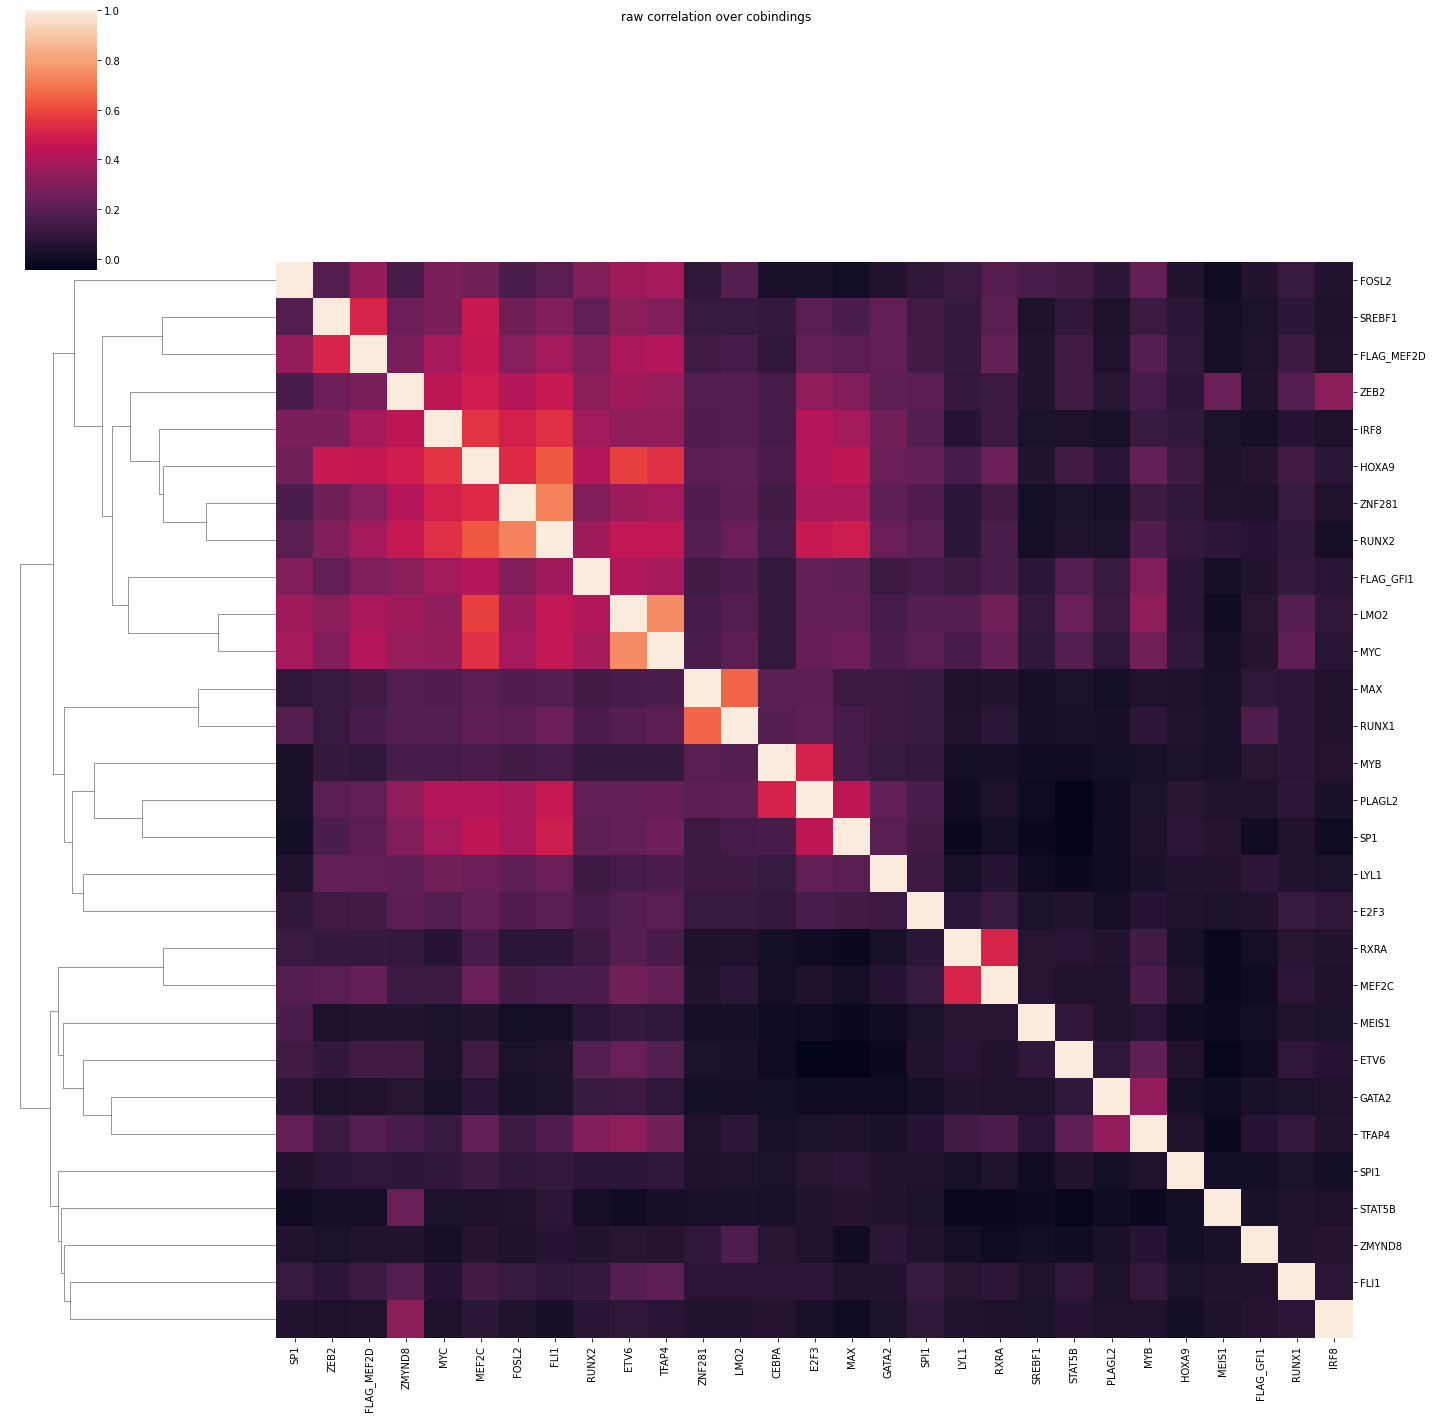

In [129]:
#raw correlation over cobindings
fig = sns.clustermap(np.corrcoef(stats.zscore(merged[set(merged.columns[cols:annot])].values.T, axis=1)), figsize=(20, 20), xticklabels=merged.columns[cols:annot], yticklabels=set(merged.columns[cols:annot])-set(['CEBPA']))
fig.ax_col_dendrogram.set_visible(False)
fig.fig.suptitle("raw correlation over cobindings")
fig.savefig("../results/"+project+'/'+version+'_'+merging_version+'_'+window+"/plots/correlation_cobinding_regular.pdf")

In [115]:
#for plotting the cobinding we are only looking at a random subset (~0.3%)
rand = np.random.choice(merged.index,5000)
viridis = cm.get_cmap('viridis', 256)

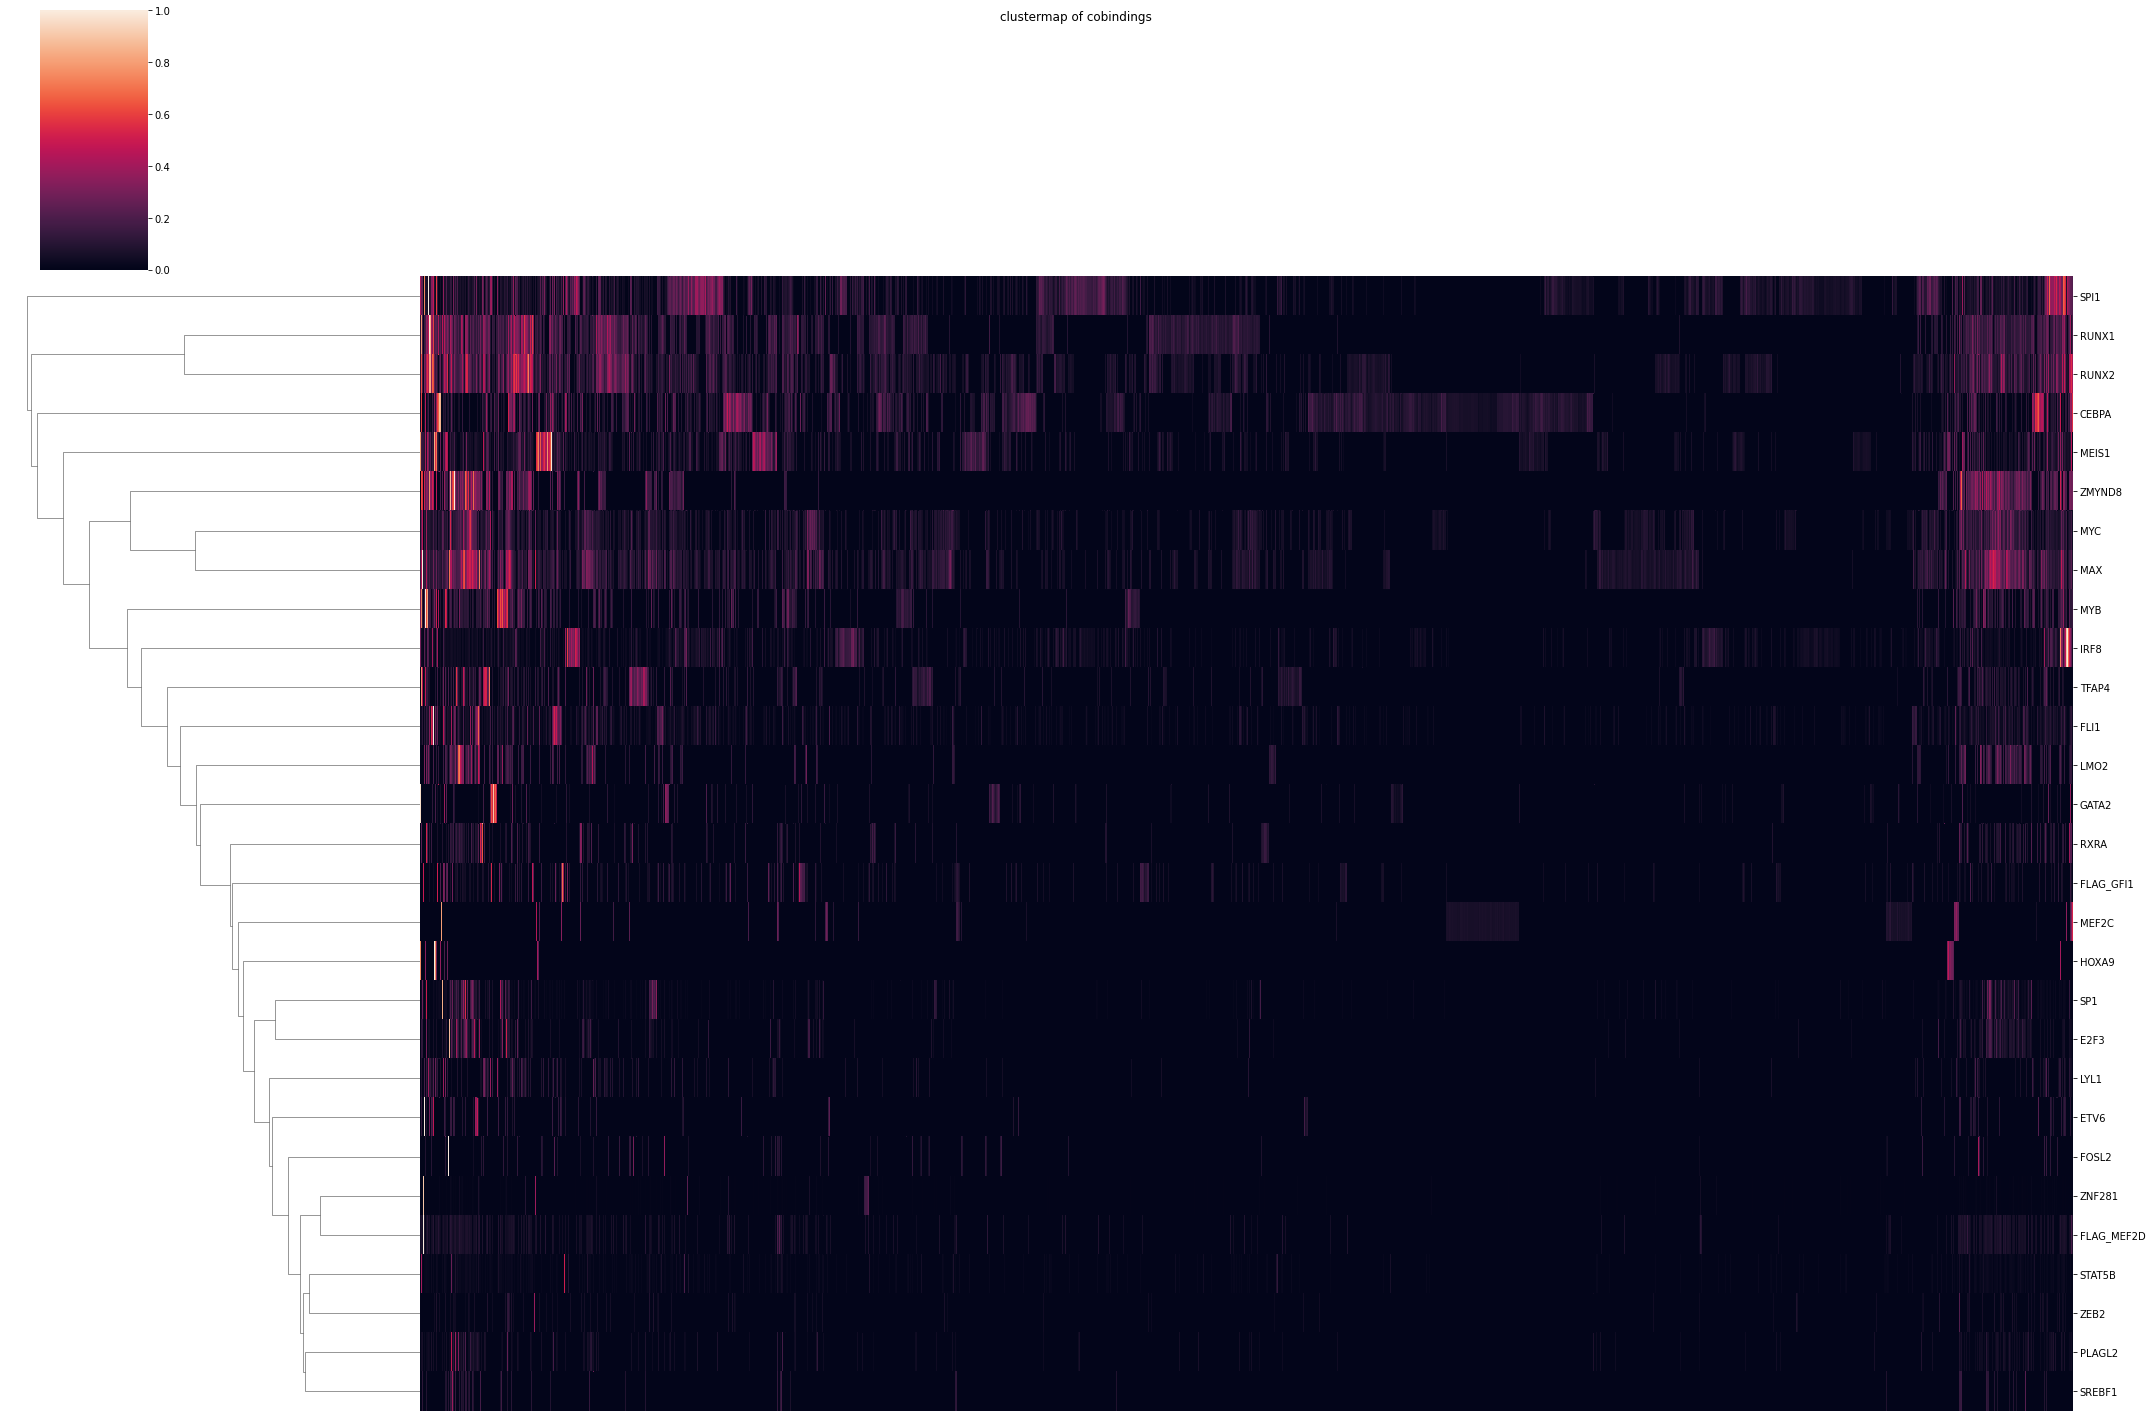

In [118]:
#clustermap of cobindings
fig = sns.clustermap(merged[merged.columns[cols:annot]].loc[rand].T, standard_scale=0, figsize=(30,20),xticklabels=False)
fig.ax_col_dendrogram.set_visible(False)
fig.fig.suptitle("clustermap of cobindings")
fig.savefig('../results/'+project+'/'+version+'_'+merging_version+'_'+window+'/plots/clustermap_cobinding_scaled.pdf')
plt.show()

## Peak annotations

In [771]:
#list of additional chips not directly used in our cobinding matrix (used for annotations)
set(mergedpeak.tf) - set(merged.columns) 

{'AFF4',
 'BRD4',
 'CDK13',
 'CDK9',
 'CEBPB',
 'CTCF',
 'ELF2',
 'FLAG_GFI1',
 'FLAG_IRF2BP2',
 'FLAG_MEF2C',
 'FLAG_SPI1',
 'FOXP1',
 'H3K27ac',
 'H3K27me3',
 'H3K36me2',
 'H3K36me3',
 'H3K4me1',
 'H3K4me3',
 'H3K79me2',
 'H3K9ac',
 'IKZF1',
 'IRF2BP2',
 'JUND',
 'LDB1',
 'MED1',
 'MEF2D',
 'MLL_KTM2A',
 'MYBL2',
 'POLII',
 'PSER2',
 'RARA',
 'SMC1',
 'WDR5'}

In [10]:
additional = {}

In [ ]:
# creating activation and repression histone signal
additional['activation'] = chip.simpleMergePeaks(mergedpeak[mergedpeak.tf.isin(["H3K27ac",'H3K79me2','H3K36me3','H3K4me3','H3K9ac','H3K4me1'])], window=10, mergedFold="max")
additional['repression'] = chip.simpleMergePeaks(mergedpeak[mergedpeak.tf.isin(['H3K27me3', 'H3K36me2'])], window=10, mergedFold="max")
# adding other additionals
for val in set(mergedpeak.tf) - (set(merged.columns) | set(remove)):
    # let's as well only use the flag version of IRF2BP2
    if val in drop: 
        continue
    additional[val] = mergedpeak[mergedpeak.tf==val]

### compute promoters

list of 30,000 promoters from https://epd.epfl.ch/get_promoters.php

In [34]:
window = 500

In [35]:
promoters = pd.read_csv('../data/'+project+'/human_epdnew_l3zqX.bed', sep='\t',header=None).rename(columns={0:'chrom',1:'start',2:'end',3:'name',5:'strand'}).drop(4,1)
promoters['foldchange']=1
promoters['name']=[i[:-2] for i in promoters['name']]
promoters['start']-= int(window/2)
promoters['end']+= int(window/2)
additional['promoter'] = promoters

In [36]:
promoters

,chrom,start,end,name,strand,foldchange
0,chr1,959005,959506,NOC2L,-,1
1,chr1,960382,960883,KLHL17,+,1
2,chr1,966231,966732,PLEKHN1,+,1
3,chr1,976430,976931,PERM1,-,1
4,chr1,999846,1000347,HES4,-,1
...,...,...,...,...,...,...
29593,chrX,155612701,155613202,TMLHE,-,1
29594,chrX,155767501,155768002,SPRY3,+,1
29595,chrX,155881094,155881595,VAMP7,+,1
29596,chrY,18992568,18993069,CD24,-,1


### adding super enhancers

In [164]:
peaks = !ls ../../data/$project/MV411peak/*H3K27ac*
peaks

['../../data/Cobinding_ChIP/MV411peak/mp136-MV411-H3K27ac_R1_peaks.broadPeak',
 '../../data/Cobinding_ChIP/MV411peak/mp183-MV411_DMSO-H3K27ac_R1_peaks.broadPeak',
 '../../data/Cobinding_ChIP/MV411peak/mp702-MV411_DMSO-H3K27ac_R1_peaks.broadPeak',
 '../../data/Cobinding_ChIP/MV411peak/mp70-MV411-H3K27ac_R1_peaks.broadPeak',
 '../../data/Cobinding_ChIP/MV411peak/mp734-MV411_DMSO-H3K27ac_R1_peaks.broadPeak',
 '../../data/Cobinding_ChIP/MV411peak/mp88-MV411-H3K27ac_R1_peaks.broadPeak']

In [ ]:
# we need to load all H3K27ac's bam files
! mkdir ../../data/$project/bams/
! gsutil -m cp gs://amlproject/Chip/$project/bwa/mergedLibrary/*MV411*H3K27ac* ../../data/$project/bams/
! gsutil cp gs://amlproject/Chip/res/bwa/mergedLibrary/mp99* ../../data/$project/bams/


In [163]:
bams = ! ls ../../data/$project/bams/*MV411*.bam
bais = ! ls ../../data/$project/bams/*MV411*.bai
bais, bams

(['../../data/Cobinding_ChIP/bams/mp183-MV411_DMSO-H3K27ac_R1.mLb.clN.sorted.bam.bai',
  '../../data/Cobinding_ChIP/bams/mp702-MV411_DMSO-H3K27ac_R1.mLb.clN.sorted.bam.bai',
  '../../data/Cobinding_ChIP/bams/mp70-MV411-H3K27ac_R1.mLb.clN.sorted.bam.bai',
  '../../data/Cobinding_ChIP/bams/mp734-MV411_DMSO-H3K27ac_R1.mLb.clN.sorted.bam.bai',
  '../../data/Cobinding_ChIP/bams/mp88-MV411-H3K27ac_R1.mLb.clN.sorted.bam.bai',
  '../../data/Cobinding_ChIP/bams/mp99-MV411-INPUT_R1.mLb.clN.sorted.bam.bai'],
 ['../../data/Cobinding_ChIP/bams/mp183-MV411_DMSO-H3K27ac_R1.mLb.clN.sorted.bam',
  '../../data/Cobinding_ChIP/bams/mp702-MV411_DMSO-H3K27ac_R1.mLb.clN.sorted.bam',
  '../../data/Cobinding_ChIP/bams/mp70-MV411-H3K27ac_R1.mLb.clN.sorted.bam',
  '../../data/Cobinding_ChIP/bams/mp734-MV411_DMSO-H3K27ac_R1.mLb.clN.sorted.bam',
  '../../data/Cobinding_ChIP/bams/mp88-MV411-H3K27ac_R1.mLb.clN.sorted.bam',
  '../../data/Cobinding_ChIP/bams/mp99-MV411-INPUT_R1.mLb.clN.sorted.bam'])

In [159]:
ls "../../genepy/genepy/epigenetics/rose"

annotation/        ROSE_bamToGFF_turbo.py*  ROSE_main.py*        ROSE_utils.pyc
README.txt*        ROSE_callSuper.R*        ROSE_main_turbo.py*
ROSE_bamToGFF.py*  ROSE_geneMapper.py*      ROSE_utils.py*


In [161]:
ls "../src/ROSEv2"

annotation/   README.md               ROSE_geneMapper.py  ROSE_utils.pyc
LICENSE       ROSE_bamToGFF.py        ROSE_main.py
patch.sh*     ROSE_bamToGFF_turbo.py  ROSE_main_turbo.py
__pycache__/  ROSE_callSuper.R        ROSE_utils.py


In [184]:
async def myfunct(a):
    for i in range(1000):
        a +=a
    print(a)
    return a

In [181]:
#calling ROSE
import asyncio
helper.createFoldersFor('../../data/'+project+'/ROSE/')
for i, peak in enumerate(peaks):
    if i < 2:
        continue
    asyncio.run(chip.MakeSuperEnhancers(peak,
                             bamFile=bams[i],
                             baiFile=bais[i],
                             controlBam= bams[-1],
                             controlBai= bais[-1],
                             outdir ='../../../../data/'+project+'/ROSE/',
                             rosePath="../../genepy/genepy/epigenetics/rose/")) #no cd -

we are going to move your input files to ../../genepy/genepy/epigenetics/rose/
finished.. moving them back to their original folder


SystemError: ROSE failed:CompletedProcess(args='cd ../../genepy/genepy/epigenetics/rose/ && python ROSE_main.py -g hg38 -i mp702-MV411_DMSO-H3K27ac_R1_peaks.broadPeak.bed -r mp70-MV411-H3K27ac_R1.mLb.clN.sorted.bam -o ../../../../data/Cobinding_ChIP/ROSE/ -t 2500 -c mp99-MV411-INPUT_R1.mLb.clN.sorted.bam', returncode=1, stdout=b'USING ../../../../data/Cobinding_ChIP/ROSE/gff/mp702-MV411_DMSO-H3K27ac_R1_peaks.broadPeak.gff AS THE INPUT GFF\nUSING hg38 AS THE GENOME\nMAKING START DICT\nLOADING IN GFF REGIONS\nCHECKING INPUT TO MAKE SURE EACH REGION HAS A UNIQUE IDENTIFIER\nREFERENCE COLLECTION PASSES QC\nSTITCHING REGIONS TOGETHER\nPERFORMING REGION STITCHING\n', stderr=b'Traceback (most recent call last):\n  File "ROSE_main.py", line 463, in <module>\n    main(True)\n  File "ROSE_main.py", line 337, in main\n    stitchedCollection, debugOutput = regionStitching(inputGFFFile, stitchWindow, tssWindow, annotFile, removeTSS)\n  File "ROSE_main.py", line 66, in regionStitching\n    tssLoci.append(ROSE_utils.makeTSSLocus(geneID, startDict, tssWindow, tssWindow))\n  File "/home/jeremie/genepy/genepy/epigenetics/rose/ROSE_utils.py", line 576, in makeTSSLocus\n    start = startDict[gene][\'start\'][0]\nTypeError: \'map\' object is not subscriptable\n')

In [60]:
#merging them all as well into one superenhancer set
rose = chip.simpleMergePeaks(chip.ReadRoseSuperEnhancers("../../data/"+project+"/ROSE/"), window=1000).drop(columns=["relative_summit_pos","-log10pvalue","-log10qvalue"])
# we get only enhacers supported by at least 1/3rd of our chips (>1)
rose = rose[rose[rose.columns[5:]].astype(bool).sum(1)>1]
additional['super_enhancer'] = rose.sort_values(by =['chrom', 
                                                     'start', 'end']).reset_index(drop = True)

0.3500474533375514

0.5678582726985131

### adding ATACseq data

In [ ]:
! gsutil cp gs://amlproject/ATAC/MV411/mergedReplicate/macs/broadPeak/ATAC_*.broadPeak ../../data/$project/MV411peak/

In [ ]:
atac = !ls ../../data/$project/MV411peak/ATAC_*
for i,v in enumerate(atac):
    a = chip.loadPeaks(v, isMacs=False)
    a = a[['chrom','start',"end","peak_number",'foldchange']]
    a['strand'] = '+'
    additional['ATAC' if len(atac)==1 else 'ATAC'+str(i)] = a 
    #TODO: merge multiple atacseqs
#creating a folder to save all marks for cchromHMM
helper.createFoldersFor("../results/"+project+"/"+version+'_'+merging_version+'_'+window+"/MV411Merged/")
a.to_csv('../results/'+project+"/"+version+'_'+merging_version+'_'+window+'/MV411Merged/ATAC.bed',index=False,sep='\t')

In [ ]:
# saving all marks
for i in set(mergedpeak.tf):
    a = mergedpeak[mergedpeak.tf==i][['chrom','start',"end",'peak_number',"foldchange"]]
    a['strand']='+'
    a.to_csv("../results/" + project + "/" + version + '_' + merging_version + '_' + window + "/MV411Merged/" + i + '.bed', sep='\t', index=False)

### Running and adding ChromHMM

In [ ]:
#list of interesting marks for ChromHMM
l = ["H3K27ac", "H3K27me3", "H3K36me3", "H3K4me1", "H3K4me3", "H3K9me3"]

In [ ]:
## computing CHROMHMM
#!mkdir ../results/chromHMM/
outdir = '../results/chromHMM/' + version + '_' + merging_version + '_' + window + '/'
data = pd.DataFrame([['MV411'] * len(l), l,["../results/" + project + "/" + version + '_' + merging_version + '_' + window + '/MV411Merged/' + i + '.bed' for i in l]]).T

chrombed = chip.runChromHMM(outdir, data, numstates=15, datatype = 'bed', chromHMMFolderpath="../src/ChromHMM/", control_bam_dir = None)['MV411']

In [ ]:
# state information
from IPython.display import Image, display
im = ! ls $out*.png
for val in im:
    display(Image(filename=val))

In [ ]:
#setting state colors for plots
statetocol={i: chrombed[chrombed['state']==i].iloc[0]['color'] for i in set(chrombed['state'])}
statetocol.update({0:'0,0,0'})
for i,v in statetocol.items():
    statetocol[i] = tuple([int(i)/256 for i in v.split(',')])

In [ ]:
#renaming the states (and some other marks)
rn = {'SMC1':'cohesin', 'MED1':'mediator', 'ATAC':'open regions','state_1':'acti_state', 'state_2':'elong_state', 
      'state_5':'start_state', 'state_6':'repres_state'}
annot = len(merged.columns)
annot

In [55]:
annot = 37

### merging 
merging everything from additionals into the cobinding matrix

In [ ]:
merged.columns[:annot+1]

In [ ]:
#chrombed['foldchange']= chrombed['state']
#merged['HMM_states'] = chip.putInBed(merged[merged.columns[:cols]], chrombed, window=1, mergetype='first')
for key, val in additional.items():
    if key in merged.columns:
        continue
    print(key)
    if len(val)>1 and key not in ['FLAG_MEF2C']:
        merged[key] = chip.putInBed(merged[merged.columns[:cols]],val)
merged = merged.replace(np.nan,0)

In [61]:
merged["super_enhancer"] = chip.putInBed(merged[merged.columns[:cols]],additional["super_enhancer"])
merged = merged.replace(np.nan,0)

9555 were merged into conscensus


In [63]:
merged.loc[merged[merged["promoter"]>0].index, 'super_enhancer'] = 0

In [67]:
merged['enhancer'] = merged['H3K27ac']
merged.loc[merged[(merged["promoter"]>0) | merged["super_enhancer"]>0].index, 'enhancer'] = 0

In [100]:
rm = ["FLAG_IRF2BP2", "GFI1", "FLAG_SPI1", "activation", "repression"]
merged = merged.drop(columns=rm)

KeyError: "['FLAG_IRF2BP2' 'GFI1' 'FLAG_SPI1' 'activation' 'repression'] not found in axis"

In [101]:
l = merged.columns.tolist()
l.remove("FLAG_GFI1")
merged = merged[l[:cols]+["FLAG_GFI1"] + l[cols:]]

#### total size of the cobinding matrix on the DNA

In [22]:
sum([v['end'] - v["start"] for k, v in merged.iterrows()])

100544511

In [ ]:
#setting each state as a separate annotation
for i in range(1,1+numstates):
    merged['state_'+str(i)] = (merged.HMM_states==i).astype(float)
merged = merged.drop(columns=['HMM_states'])
# renaming
merged = merged.rename(columns=rn)

In [41]:
merged = merged.drop(columns="FLAG_MEF2C")

In [42]:
merging_version="remove_single"
window="150"
version

'v3'

In [43]:
merged = merged[merged[merged.columns[cols:]].astype(bool).sum(1)>1].reset_index(drop=True)

In [130]:
merged.to_csv('../results/'+project+'/'+version+'_'+merging_version+'_'+window+'/merged_with_annotations.bed.gz', sep='\t',index=None)

In [21]:
merged = pd.read_csv('../results/'+project+'/'+version+'_'+merging_version+'_'+window+'/merged_with_annotations.bed.gz', sep='\t')

## In depth look at the cobinding matrix

First looking at the Basic Information about each annotations: total number of peaks, max peak signel, mean peak signal, stdev of peak signals

In [131]:
# Showing Basic Information about each annotations
info = pd.concat([merged[merged.columns[cols:]].astype(bool).sum(0),
           merged[merged.columns[cols:]].max(),
           merged[merged.columns[cols:]].replace(0, np.NaN).mean(),
          merged[merged.columns[cols:]].replace(0, np.NaN).var()],axis=1).rename(columns={0:'sum',1:'max',2:'mean',3:'std'})
info.to_csv('../results/'+project+'/'+version+'_'+merging_version+'_'+window+'/info.tsv')
info.iloc[:60]

,sum,max,mean,std
FLAG_GFI1,20523,82.751400,6.206940,34.178133
CEBPA,53458,123.662740,10.535187,63.454255
HOXA9,1262,36.844650,7.178396,11.753419
PLAGL2,13985,1424.570000,8.476812,277.332037
MEIS1,50484,99.050100,10.185620,103.733906
ETV6,6662,80.067433,9.830874,41.846204
RUNX1,51606,85.437050,8.450248,24.594157
FOSL2,4068,367.017000,10.675116,128.124885
FLI1,52209,512.890000,16.482456,447.866582
GATA2,9962,191.227000,17.285271,399.246760


In [78]:
info.iloc[60:]

,sum,max,mean,std
MED1,35891,29.567060,3.881317,1.558367
promoters,12574,1.000000,1.000000,0.000000
enhancer,36758,17.948550,3.892768,1.774443
super_enhancer,8774,36.169492,5.990120,11.152145


In [870]:
touse = ['activation', 'repression', 'FLAG_IRF2BP2', 'cohesin', 'H3K79me2', 'H3K27me3', 'H3K27ac','H3K4me3', 'FOXP1', 'MLL_KTM2A', 'RARA', 'IKZF1','H3K18', 'H3K36me2', 'H3K36me3', 'H3K9ac', 'H3K4me1', 'POLII', 'mediator', 'open regions', 'promoters', 'super_enhancer', 'regular_enhancer']

In [59]:
merged[merged.columns[annot:]]

,activation,repression,ELF2,JUND,FLAG_SPI1,FLAG_IRF2BP2,SMC1,LDB1,H3K79me2,WDR5,...,PSER2,H3K36me3,H3K9ac,CDK13,H3K4me1,POLII,MED1,promoters,superenhancer,enhancer
0,3.89958,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0000,0.0,0.0,0.0,0.0,0.000000,3.65379,0.0,NaN,3.89958
1,3.18274,0.000000,0.0,0.0,0.0,0.0,11.858755,0.0,0.0,0.0,...,0.0000,0.0,0.0,0.0,0.0,4.454133,3.14727,0.0,NaN,3.18274
2,0.00000,3.285105,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,25.1549,0.0,0.0,0.0,0.0,4.454133,3.01038,0.0,NaN,0.00000
3,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,25.1549,0.0,0.0,0.0,0.0,4.454133,3.01038,0.0,NaN,0.00000
4,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,NaN,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142965,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,NaN,0.00000
142966,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,NaN,0.00000
142967,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,NaN,0.00000
142968,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,NaN,0.00000


In [76]:
ma

activation         29.194000
repression         17.297600
ELF2              114.326900
JUND               63.074500
FLAG_SPI1          64.507200
FLAG_IRF2BP2       30.638700
SMC1               86.709700
LDB1               30.134700
H3K79me2           16.227400
WDR5               42.445660
H3K27ac            18.188992
H3K27me3           16.938800
FLAG_GFI1          82.751400
MYBL2              35.384400
CDK9               65.188600
H3K4me3            29.194000
FOXP1              78.395000
MLL_KTM2A          17.241300
RARA              343.553000
IKZF1              75.841100
AFF4               96.589900
CTCF               77.679100
BRD4               13.187515
CEBPB             150.145000
H3K36me2           17.297600
PSER2              59.964700
H3K36me3           14.576100
H3K9ac             20.637600
CDK13              75.114900
H3K4me1             5.403210
POLII              94.570360
MED1               29.567060
promoters           1.000000
enhancer           17.948550
super_enhancer

In [132]:
rand = np.random.choice(merged.index,5000)
viridis = cm.get_cmap('viridis', 256)

data = merged[merged.columns[annot:]]
ma = data.max()
mi = data.min()
data = data.loc[rand]
data = (data-mi)/(ma-mi)
for val in data.columns:
    a = [viridis(int(v*256)) for v in data[val]]
    data[val] = a

### cobinding matrix

A matrix computed from overlapping binding profiles of TFs composing the CRC (bottom / red color). any peak around  window of X (150bp) to another get merged into a single, longer peak that has both TFs. Under this new set of peaks, we are looking for peaks from other proteins and histone marks (top / blue colors). This new addition won't change the matrix itself.

FileNotFoundError: [Errno 2] No such file or directory: '../results/Cobinding_ChIP/plots/v3_remove_single_150/clustermap_cobinding_scaled_full_annotations.pdf'

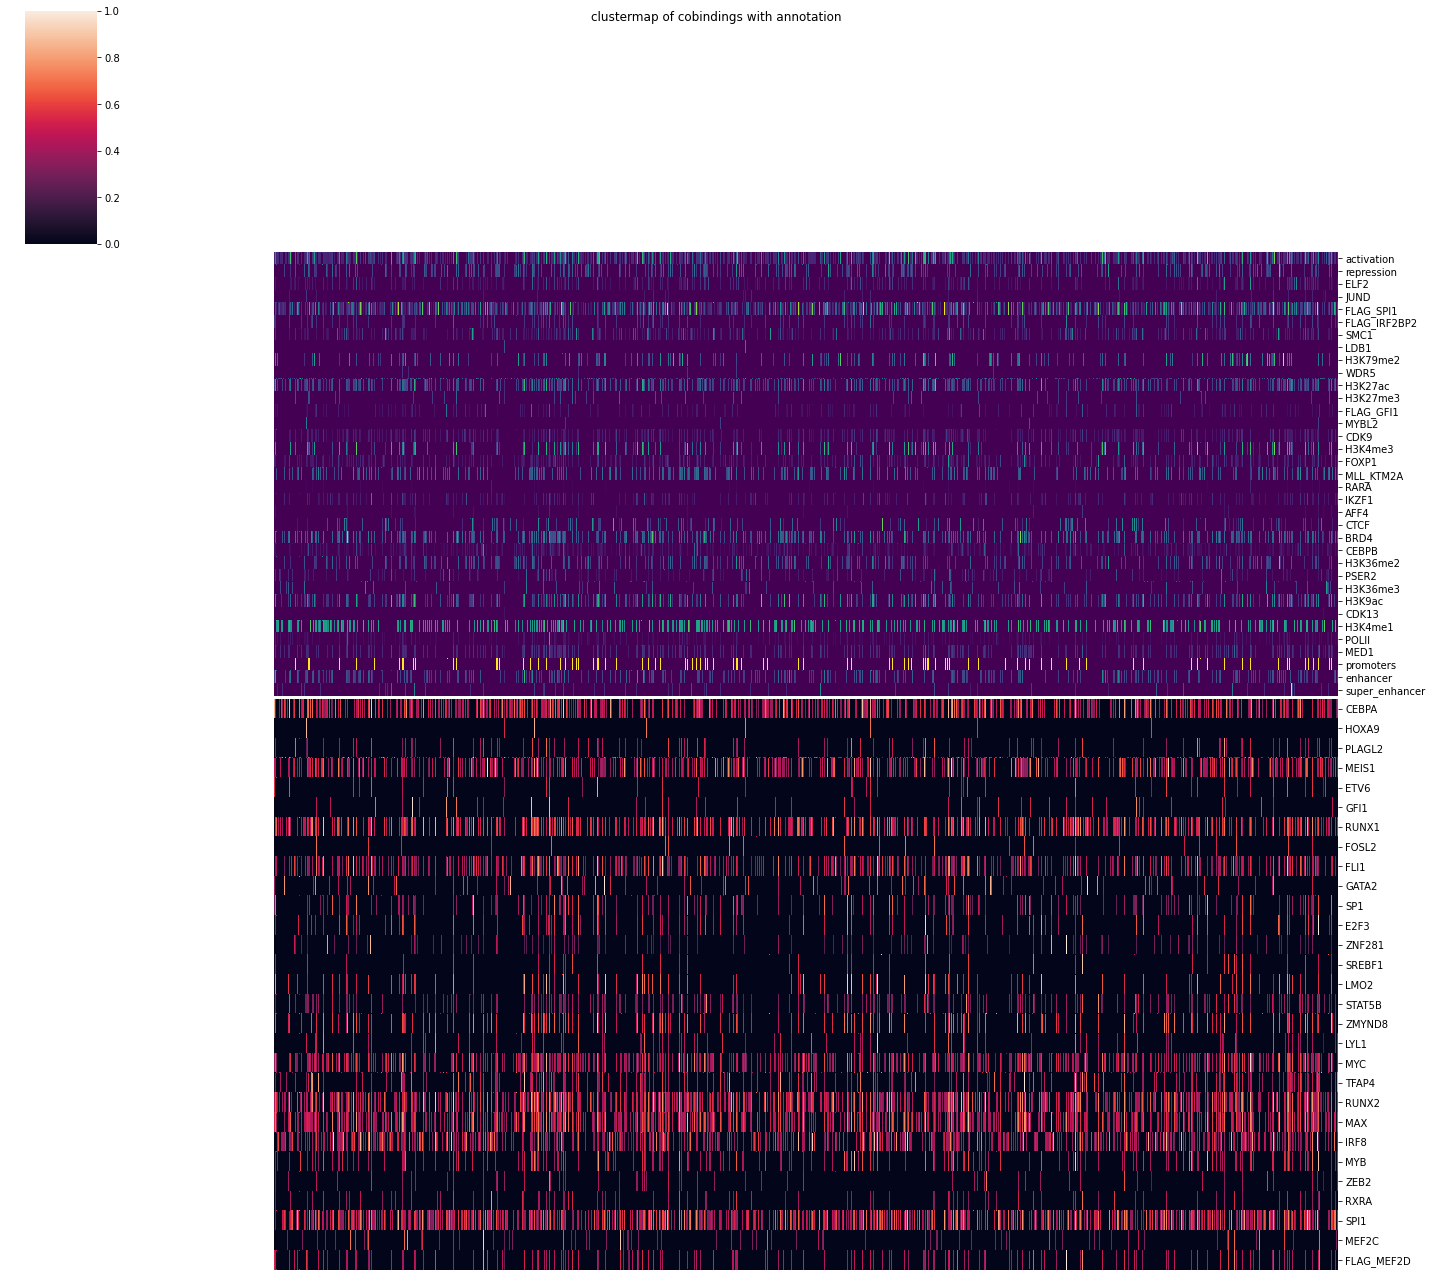

In [71]:
#clustermap of cobindings with annotation
fig = sns.clustermap(np.log2(1.01+merged[merged.columns[cols:annot]].loc[rand].T), standard_scale=0, colors_ratio=0.01, figsize=(20,18), col_colors = data, xticklabels=False, row_cluster=False, col_cluster=False)
fig.ax_col_dendrogram.set_visible(False)
fig.fig.suptitle("clustermap of cobindings with annotation")

fig.savefig('../results/'+project+'/plots/'+version+'_'+merging_version+'_'+window+'/clustermap_cobinding_scaled_full_annotations.pdf')
plt.show()

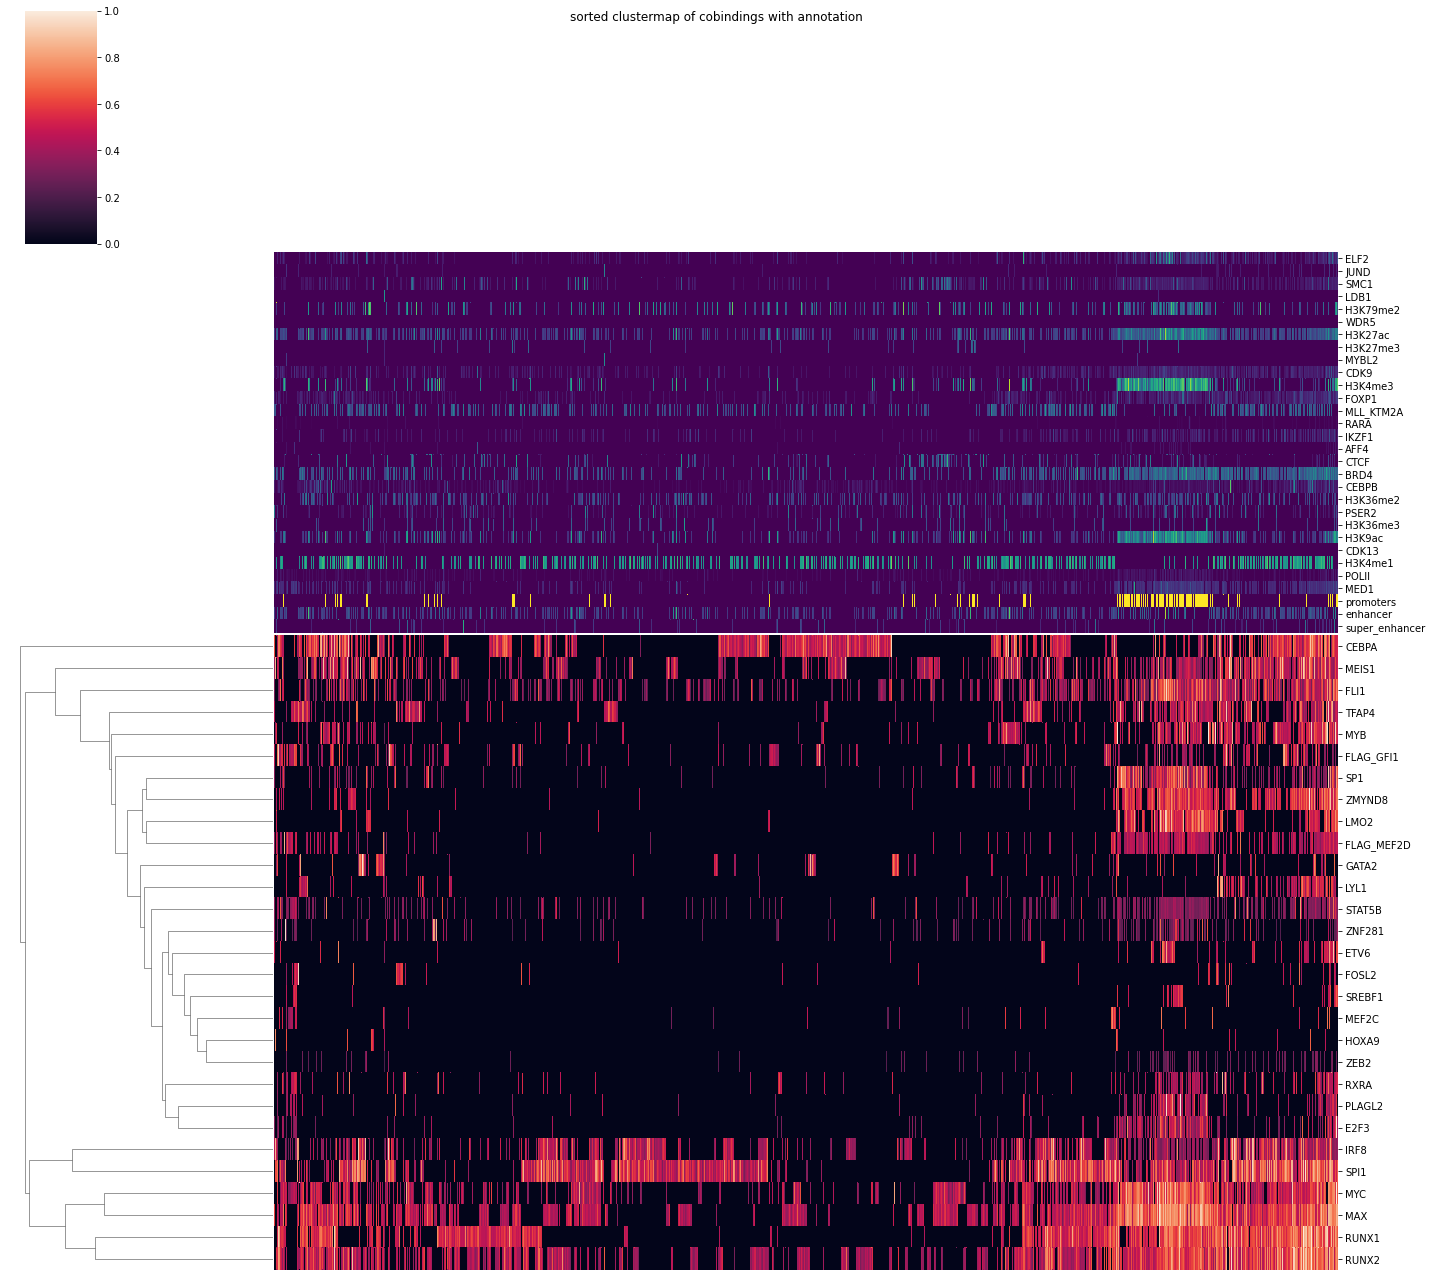

In [133]:
#sorted clustermap of cobindings with annotation
fig = sns.clustermap(np.log2(1.01+merged[merged.columns[cols:annot]].loc[rand].T), vmin=0, vmax=1, figsize=(20,18), colors_ratio=0.01, standard_scale=0, col_colors=data, xticklabels=False)
fig.ax_col_dendrogram.set_visible(False)
fig.fig.suptitle("sorted clustermap of cobindings with annotation")
fig.savefig('../results/'+project+'/'+version+'_'+merging_version+'_'+window+'/plots/clustermap_cobinding_scaled_full_annotation_sorted.pdf')
plt.show()

### TSNE of CRC binding profile

A 2D plot showing the similarity of different transcription factors. Plot using TSNE where similarity is represented by local distances. the similarity is computed on peak signal for each TF across the cobinding matrix. 

In [3]:
%store -r merged
%store -r cols
%store -r project
%store -r version
%store -r merging_version
%store -r window
%store -r annot

In [6]:
#scatter plot of distance of TF in cobinding space
red = TSNE(2,3).fit_transform(PCA(10).fit_transform(stats.zscore(merged[merged.columns[cols:annot]]).T))
pd.DataFrame(index=merged.columns[cols:annot],data=red, columns=['x','y']).to_csv("../results/"+project+'/'+version+"_"+merging_version+"_"+window+"/tsne_coordinates_crc_only.csv")
a = plot.scatter(red, radi=10, labels=merged.columns[cols:annot], showlabels=True, title="scatter plot of CRC distance in cobinding space", folder="../results/"+project+'/'+version+"_"+merging_version+"_"+window+"/plots/")

/opt/conda/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass perplexity=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


/opt/conda/lib/python3.8/site-packages/bokeh/io/saving.py:126: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")
/opt/conda/lib/python3.8/site-packages/bokeh/io/saving.py:139: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  warn("save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'")


### TSNE of TF binding profile

A 2D plot showing the similarity of different transcription factors. Plot using TSNE where similarity is represented by local distances. the similarity is computed on peak signal for each TF across the cobinding matrix. 

In [19]:
#scatter plot of distance of TF in cobinding space
red = TSNE(2,6).fit_transform(stats.zscore(merged[merged.columns[cols:]]).T)
pd.DataFrame(index=merged.columns[cols:],data=red, columns=['x','y']).to_csv("../results/"+project+'/'+version+"_"+merging_version+"_"+window+"/tsne_coordinates_all.csv")
plot.scatter(red, radi=5, labels=merged.columns[cols:], colors=[1 if val in crc else 0 for val in merged.columns[cols:]], showlabels=True, title="scatter plot of distance of TF in cobinding space", folder="../results/"+project+'/'+version+"_"+merging_version+"_"+window+"/plots/")

/opt/conda/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass perplexity=6 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


/opt/conda/lib/python3.8/site-packages/bokeh/io/saving.py:126: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")
/opt/conda/lib/python3.8/site-packages/bokeh/io/saving.py:139: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  warn("save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'")


Figure(id='3542', ...)

In [938]:
%store merged
%store merging_version

Stored 'merged' (DataFrame)
Stored 'merging_version' (str)


## Comparison to a random distribution 

### computation:

we are evalutating each event's probability 1 binding, 2 binding, n binding.., as a binomial over the amount of proability p_i with n retries corresponding to the size of the conscensus peak set.
the probability p_i of this binomial is the sum of probabilities of having tf a binding with b for all possible combination of tf. 
the number of combination is k amongst n, n being 33, k going from 1 to 29
we compute 

$p(a & b) = p(a)\*p(b) =p(ab)$

and 

$p(a & b) | p(a & c) = p(ab) + p(ac) - p(abc)$

for a,b,c,d:

$p(ab) + p(ac) + p(ad) + p(bc) + p(bd) + p(cd) - {3\choose 2}*(p(abc) - p(abd) - p(bcd) - p(acd)) - {4\choose 2}*p(abcd)$

now we will be making the expected distribution

In [889]:
proba = (merged[merged.columns[cols:annot]].astype(bool).sum(0)/len(merged)).tolist()
size= len(proba)+1
sums = helper.makeCombinations(size, proba)

29
40920
28
237336
27
1107568
26
4272048
25
13884156
24
38567100
23
92561040
22
193536720
21
354817320
20
573166440
19
818809200
18
1037158320
17
1166803110
16
1166803110
15
1037158320
14
818809200
13
573166440
12
354817320
11
193536720
10
92561040
9
38567100
8
13884156
7
4272048
6
1107568
5
237336
4
40920
3
5456
2
528
1
33


In [890]:
# we are saving the expected distributions (as it is long to compute)
version = "v3"
merging_version = "simpleMerge"
window = "150"
a = '../results/' + project + '/*_sums.json'
!ls $a

../results/Cobinding_ChIP/v2_simpleMerge_150_sums.json
../results/Cobinding_ChIP/v3_remove_single_150_sums.json


In [891]:
helper.dictToFile(sums,'../results/' + project + '/' + version + '_' + merging_version +  '_' + window+'/sums.json')

In [3]:
sums = helper.fileToDict('../results/' + project + '/' + version + '_' + merging_version +  '_' + window+'sums.json')
s={} 
for k,v in sums.items():
    s[int(k)] = sums[k]
sums = s
sums

NameError: name 'merging_version' is not defined

In [ ]:
# computing the ratio to expected distribution
for i in range(len(sums)-1,0,-1):
    print(i,stats.binom.mean(len(merged), sums[i]),stats.binom.var(len(merged), sums[i]))
    sums[i] = [stats.binom.mean(len(merged), sums[i]),stats.binom.var(len(merged), sums[i])]

### distribution of cobindings

Barplot of the distribution of co-occurrences of peaks across the cobinding matrix

In [10]:
# peaks that have multiple TFs

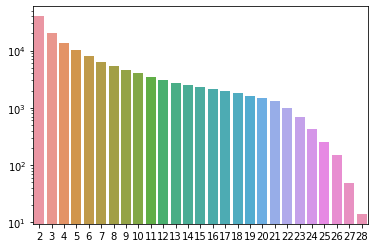

In [888]:
#we are looking at the distribution of pseudo-enhancers per cobound regions
counts,val = np.unique(merged[merged.columns[cols:annot]].astype(bool).sum(1).values, return_counts=True)
fig = sns.barplot(data=pd.DataFrame(val, index=counts,columns=['counts']).T)
fig.set_yscale("log")
fig.figure.savefig("../results/"+project+'/'+version+'_'+merging_version+'_'+window+"/plots/cobinding_distribution.pdf")

plotting the ratios

In [11]:
# what we'd expect from random distribution

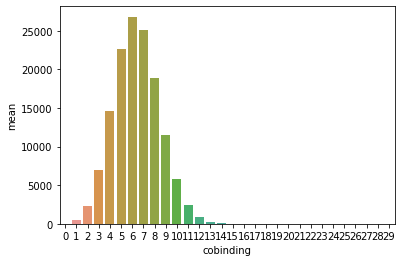

In [941]:
cobind = pd.DataFrame(sums).T.rename(columns={0:'mean',1:'var'})
cobind['cobinding']=cobind.index
fig = sns.barplot("cobinding","mean", data=cobind, ci=None)
#plt.errorbar(x=range(0,len(cobind)),y=cobind['mean'],
            #yerr=cobind['var'], fmt='none', c= 'r')
plt.savefig("../results/"+project+'/'+version+'_'+merging_version+'_'+window+"/plots/expected_cobinding_distribution.pdf")

Let's look at the enrichment of our current dataset

In [12]:
# how much we deviate from random distribution

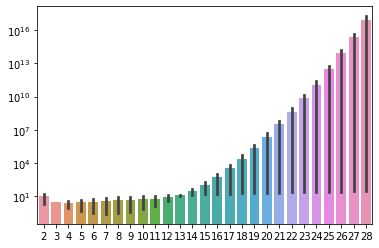

In [894]:
res = pd.DataFrame()
res['change']=val/cobind[cobind.cobinding.isin(counts)]['mean']
res['count']=list(res.index)
fig = sns.barplot(data=res.T).set_yscale("log")
plt.savefig("../results/"+project+'/'+version+'_'+merging_version+'_'+window+"/plots/cobinding_enrichment.pdf")

### cobinding enrichment

Barplot (total + zoomed) of the enrichment in number of cobound proteins to a conscensus peak. This enrichment is computed from the expected distribution of cobindings given by the frequencies of peaks for each proteins, over the cobinding matrix. Cobound proteins are defined from called peaks, using macs2 on chipseq data.

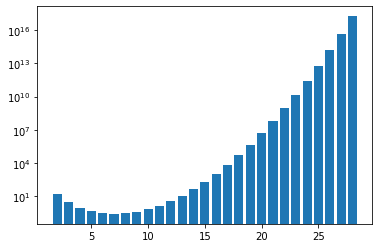

In [895]:
fig = plt.bar(res['count'],res['change'],log=True)
plt.savefig("../results/"+project+'/'+version+'_'+merging_version+'_'+window + "/plots/cobinding_enrichment_matplotlib.pdf")
plt.show()

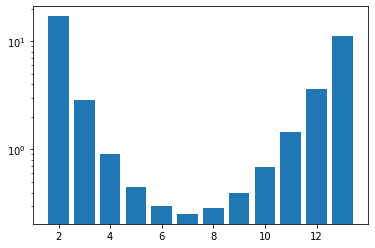

In [896]:
m =12
fig = plt.bar(res.iloc[:m]['count'],res.iloc[:m]['change'],log=True)
plt.savefig("../results/"+project+'/'+version+'_'+merging_version+'_'+window+"/plots/cobinding_enrichment_zoomed.pdf")
plt.show()

## Saving

In [887]:
%store chrombed
%store mergedpeak
%store cols
%store annot
%store version
%store window
%store crc

Stored 'merged' (DataFrame)
Stored 'chrombed' (DataFrame)
Stored 'mergedpeak' (DataFrame)
Stored 'cols' (int)
Stored 'annot' (int)
Stored 'version' (str)
Stored 'merging_version' (str)
Stored 'window' (str)
